# yasqat — Yet Another Sequence Analytics Toolkit

A comprehensive showcase of **yasqat**, a Polars-based toolkit for categorical sequence analysis.
This notebook demonstrates the full API using two realistic synthetic datasets:

1. **Employment trajectories** — 300 career sequences across 30 time periods with 8 labour-market states
2. **Financial customer journeys** — 5,000 banking customers with 35 states across a full calendar year

### Table of Contents

| # | Section | Highlights |
|---|---------|------------|
| 1 | Data Generation | Markov sequences, financial journeys, `Alphabet` |
| 2 | Core Data Structures | `StateSequence`, `EventSequence`, `SequencePool` |
| 3 | Descriptive Statistics | All 16 statistics (entropy, turbulence, complexity, …) |
| 4 | Transition Analysis | Rate matrices, first occurrence, duration stats |
| 5 | Normative Indicators | Precarity, integration, degradation, and 4 more |
| 6 | Visualization | All 9 plot types (index, distribution, entropy, …) |
| 7 | Distance Metrics | All 18 metrics: OM, DTW, LCS, Hamming, … |
| 8 | Clustering | PAM, hierarchical, CLARA, quality, representatives |
| 9 | Frequent Subsequence Mining | Pattern extraction with support thresholds |
| 10 | Discrepancy Analysis | Pseudo-R², permutation tests, dissimilarity trees |
| 11 | Filtering & Selection | 7 criteria, combined filters, Polars expressions |
| 12 | Data I/O | CSV, JSON, Parquet, wide format, type inference |
| 13 | IntervalSequence & Trajectory | Spell-based data, multi-channel trajectories |
| 14 | Scaling | 30,000-user financial analytics |
| 15 | Summary | Quick-reference API table |

In [1]:
# Common imports
from __future__ import annotations

import numpy as np
import polars as pl

## 1. Data Generation

We create two synthetic datasets that will be used throughout the notebook.
The **employment dataset** models labour-market transitions (inspired by EU-SILC panel data),
while the **financial dataset** represents realistic banking customer journeys.

### 1.1 Employment Trajectories (Markov Chain)

We define 8 labour-market states and a handcrafted 8×8 transition matrix
that encodes realistic dynamics:

| Code | State | Transition behaviour |
|------|-------|---------------------|
| FT | Full-time | Dominant (0.75 self-transition) |
| PT | Part-time | Moderate persistence (0.60) |
| SE | Self-employed | Moderate persistence (0.65) |
| UE | Unemployed | Transient (0.30 → strong outflow to FT/ED) |
| ED | Education | Moderate persistence (0.55 → exits to FT) |
| PL | Parental Leave | Short spells (0.40 → returns to FT/PT) |
| RT | Retirement | Absorbing (0.99) |
| IN | Inactivity | Moderate persistence (0.50) |

In [2]:
from yasqat.synthetic.financial import generate_markov_sequences
from yasqat.core.alphabet import Alphabet

# Define 8 employment states
career_states = ["FT", "PT", "SE", "UE", "ED", "PL", "RT", "IN"]

# Handcrafted 8x8 transition matrix
#                FT    PT    SE    UE    ED    PL    RT    IN
career_tm = np.array([
    [0.75, 0.08, 0.03, 0.04, 0.02, 0.03, 0.03, 0.02],  # FT
    [0.15, 0.60, 0.05, 0.06, 0.04, 0.05, 0.02, 0.03],  # PT
    [0.10, 0.05, 0.65, 0.08, 0.03, 0.02, 0.04, 0.03],  # SE
    [0.30, 0.10, 0.05, 0.30, 0.15, 0.02, 0.01, 0.07],  # UE
    [0.25, 0.08, 0.04, 0.05, 0.55, 0.01, 0.00, 0.02],  # ED
    [0.30, 0.20, 0.03, 0.03, 0.02, 0.40, 0.00, 0.02],  # PL
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.99, 0.01],  # RT
    [0.10, 0.08, 0.03, 0.10, 0.05, 0.04, 0.10, 0.50],  # IN
])

# Generate 300 career sequences of length 30
career_df = generate_markov_sequences(
    n_sequences=300,
    sequence_length=30,
    transition_matrix=career_tm,
    states=career_states,
    seed=42,
)

print(f"Career dataset: {career_df.shape[0]} rows, {career_df.n_unique('id')} sequences")
career_df.head(10)

Career dataset: 9000 rows, 300 sequences


id,time,state
i64,i64,str
0,0,"""FT"""
0,1,"""FT"""
0,2,"""SE"""
0,3,"""SE"""
0,4,"""FT"""
0,5,"""RT"""
0,6,"""RT"""
0,7,"""RT"""
0,8,"""RT"""


In [3]:
# Build Alphabet with descriptive labels and colours
career_alphabet = Alphabet(
    states=tuple(career_states),
    labels={
        "FT": "Full-time",
        "PT": "Part-time",
        "SE": "Self-employed",
        "UE": "Unemployed",
        "ED": "Education",
        "PL": "Parental Leave",
        "RT": "Retirement",
        "IN": "Inactivity",
    },
    colors={
        "FT": "#2196F3",  # blue
        "PT": "#4CAF50",  # green
        "SE": "#FF9800",  # orange
        "UE": "#F44336",  # red
        "ED": "#9C27B0",  # purple
        "PL": "#E91E63",  # pink
        "RT": "#607D8B",  # grey
        "IN": "#795548",  # brown
    },
)

print(f"Alphabet: {career_alphabet.states}")
print(f"Labels: {career_alphabet.labels}")
print(f"Colours: {career_alphabet.colors}")

Alphabet: ('FT', 'PT', 'SE', 'UE', 'ED', 'PL', 'RT', 'IN')
Labels: {'FT': 'Full-time', 'PT': 'Part-time', 'SE': 'Self-employed', 'UE': 'Unemployed', 'ED': 'Education', 'PL': 'Parental Leave', 'RT': 'Retirement', 'IN': 'Inactivity'}
Colours: {'FT': '#2196F3', 'PT': '#4CAF50', 'SE': '#FF9800', 'UE': '#F44336', 'ED': '#9C27B0', 'PL': '#E91E63', 'RT': '#607D8B', 'IN': '#795548'}


In [4]:
# Create grouping variables for later discrepancy analysis
rng = np.random.default_rng(42)

# 3 cohorts of 100 sequences each
cohort_labels = np.array(["early"] * 100 + ["mid"] * 100 + ["late"] * 100)

# Random gender assignment
gender_labels = rng.choice(["M", "F"], size=300)

print(f"Cohort distribution: {dict(zip(*np.unique(cohort_labels, return_counts=True)))}")
print(f"Gender distribution: {dict(zip(*np.unique(gender_labels, return_counts=True)))}")

Cohort distribution: {np.str_('early'): np.int64(100), np.str_('late'): np.int64(100), np.str_('mid'): np.int64(100)}
Gender distribution: {np.str_('F'): np.int64(145), np.str_('M'): np.int64(155)}


### 1.2 Financial Customer Journeys

The `generate_financial_journeys` function simulates realistic banking lifecycles:
onboarding → product adoption → activity levels → risk events → engagement channels.
It generates event-level data with 35 states across 5 categories.

In [5]:
from yasqat.synthetic.financial import generate_financial_journeys

fin_df = generate_financial_journeys(n_users=5000, seed=42)
print(f"Financial dataset: {fin_df.shape[0]} rows, {fin_df.n_unique('id')} users")
print(f"States: {fin_df['state'].n_unique()} unique")
print(f"Columns: {fin_df.columns}")
fin_df.head(10)

Financial dataset: 528141 rows, 5000 users
States: 32 unique
Columns: ['id', 'time', 'state', 'state_category', 'date']


id,time,state,state_category,date
i64,i64,str,str,date
0,22,"""lead""","""onboarding""",2025-01-23
0,28,"""kyc_approved""","""onboarding""",2025-01-29
0,31,"""account_opened""","""onboarding""",2025-02-01
0,32,"""dormant""","""activity""",2025-02-02
0,43,"""medium_activity""","""activity""",2025-02-13
0,59,"""dormant""","""activity""",2025-03-01
0,62,"""medium_activity""","""activity""",2025-03-04
0,66,"""low_activity""","""activity""",2025-03-08
0,80,"""dormant""","""activity""",2025-03-22


### 1.3 Build Core Objects

We construct the main data structures that will be used throughout:
`SequenceConfig`, `StateSequence`, and `SequencePool`.

In [6]:
from yasqat.core.sequence import SequenceConfig, StateSequence
from yasqat.core.pool import SequencePool

# Career dataset uses default column names (id, time, state)
career_config = SequenceConfig()

# StateSequence — core representation
career_seq = StateSequence(career_df, career_config, alphabet=career_alphabet)
print(f"StateSequence: {career_seq.n_sequences()} sequences")

# SequencePool — for distance / clustering workflows
career_pool = SequencePool(career_df, career_config, alphabet=career_alphabet)
print(f"SequencePool: {len(career_pool)} sequences")

# Financial dataset
fin_config = SequenceConfig()
fin_seq = StateSequence(fin_df.select("id", "time", "state"), fin_config)
fin_pool = SequencePool(fin_df.select("id", "time", "state"), fin_config)
print(f"Financial StateSequence: {fin_seq.n_sequences()} sequences")

StateSequence: 300 sequences
SequencePool: 300 sequences
Financial StateSequence: 5000 sequences


## 2. Core Data Structures

yasqat provides four core data structures:
- **`Alphabet`** — state encoding, labels, and colours
- **`StateSequence`** — time-indexed state data with STS/SPS/DSS representations
- **`EventSequence`** — timestamped events (multiple events per time point)
- **`SequencePool`** — optimised container for distance computations

### 2.1 Alphabet

The `Alphabet` manages the mapping between state labels and integer codes.
It can be built explicitly, inferred from data, or derived from a Polars Series.

In [7]:
# from_sequence: infer alphabet from a list
alpha1 = Alphabet.from_sequence(["A", "B", "C", "A", "B"])
print(f"from_sequence: {alpha1.states}")

# from_series: infer from a Polars Series
alpha2 = Alphabet.from_series(career_df["state"])
print(f"from_series: {alpha2.states}")

# encode / decode round-trip
encoded = career_alphabet.encode(["FT", "UE", "RT"])
decoded = career_alphabet.decode(encoded)
print(f"encode(['FT','UE','RT']): {encoded}")
print(f"decode back: {decoded}")

# with_colors / with_labels return a new Alphabet
alpha3 = alpha1.with_colors({"A": "#ff0000", "B": "#00ff00", "C": "#0000ff"})
alpha3 = alpha3.with_labels({"A": "Alpha", "B": "Beta", "C": "Gamma"})
print(f"with_colors: {alpha3.colors}")
print(f"with_labels: {alpha3.labels}")

# index_of
print(f"index_of('UE'): {career_alphabet.index_of('UE')}")

from_sequence: ('A', 'B', 'C')
from_series: ('ED', 'FT', 'IN', 'PL', 'PT', 'RT', 'SE', 'UE')
encode(['FT','UE','RT']): [0 3 6]
decode back: ['FT', 'UE', 'RT']
with_colors: {'A': '#ff0000', 'B': '#00ff00', 'C': '#0000ff'}
with_labels: {'A': 'Alpha', 'B': 'Beta', 'C': 'Gamma'}
index_of('UE'): 3


### 2.2 StateSequence

`StateSequence` wraps a long-format DataFrame and provides per-sequence access,
state encoding, and three standard representations.

In [8]:
# Properties
print(f"n_sequences: {career_seq.n_sequences()}")
print(f"sequence_ids (first 10): {career_seq.sequence_ids()[:10]}")
print(f"alphabet: {career_seq.alphabet.states}")

# get_sequence — returns DataFrame for one sequence
print("\nSequence 0:")
career_seq.get_sequence(0)

n_sequences: 300
sequence_ids (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
alphabet: ('FT', 'PT', 'SE', 'UE', 'ED', 'PL', 'RT', 'IN')

Sequence 0:


id,time,state
i64,i64,str
0,0,"""FT"""
0,1,"""FT"""
0,2,"""SE"""
0,3,"""SE"""
0,4,"""FT"""
…,…,…
0,25,"""RT"""
0,26,"""RT"""
0,27,"""RT"""


In [9]:
# get_states_for_sequence — returns list of state labels
states = career_seq.get_states_for_sequence(0)
print(f"States for seq 0: {states}")

# encode_states — 2D numpy array (n_sequences × max_length)
encoded = career_seq.encode_states()
print(f"\nEncoded shape: {encoded.shape}")
print(f"Encoded seq 0: {encoded[0]}")

States for seq 0: ['FT', 'FT', 'SE', 'SE', 'FT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT']

Encoded shape: (9000,)
Encoded seq 0: 0


### 2.3 Representations: STS, SPS, DSS

Three standard formats from the sequence analysis literature:

- **STS** (State-Time Sequence) — one state per time point (the default long format)
- **SPS** (Spell) — run-length encoded spells (state + duration)
- **DSS** (Distinct Successive States) — only state transitions, no timing

In [10]:
# STS — State-Time Sequence
print("STS format (first sequence):")
sts_df = career_seq.to_sts()
print(sts_df.filter(pl.col("id") == 0))

STS format (first sequence):
shape: (30, 3)
┌─────┬──────┬───────┐
│ id  ┆ time ┆ state │
│ --- ┆ ---  ┆ ---   │
│ i64 ┆ i64  ┆ str   │
╞═════╪══════╪═══════╡
│ 0   ┆ 0    ┆ FT    │
│ 0   ┆ 1    ┆ FT    │
│ 0   ┆ 2    ┆ SE    │
│ 0   ┆ 3    ┆ SE    │
│ 0   ┆ 4    ┆ FT    │
│ …   ┆ …    ┆ …     │
│ 0   ┆ 25   ┆ RT    │
│ 0   ┆ 26   ┆ RT    │
│ 0   ┆ 27   ┆ RT    │
│ 0   ┆ 28   ┆ RT    │
│ 0   ┆ 29   ┆ RT    │
└─────┴──────┴───────┘


In [11]:
# SPS — Spell (run-length encoded)
print("SPS format (first sequence):")
sps_df = career_seq.to_sps()
print(sps_df.filter(pl.col("id") == 0))

SPS format (first sequence):
shape: (4, 6)
┌─────┬──────────┬───────┬───────┬─────┬──────────┐
│ id  ┆ spell_id ┆ state ┆ start ┆ end ┆ duration │
│ --- ┆ ---      ┆ ---   ┆ ---   ┆ --- ┆ ---      │
│ i64 ┆ u32      ┆ str   ┆ i64   ┆ i64 ┆ u32      │
╞═════╪══════════╪═══════╪═══════╪═════╪══════════╡
│ 0   ┆ 1        ┆ FT    ┆ 0     ┆ 1   ┆ 2        │
│ 0   ┆ 2        ┆ SE    ┆ 2     ┆ 3   ┆ 2        │
│ 0   ┆ 3        ┆ FT    ┆ 4     ┆ 4   ┆ 1        │
│ 0   ┆ 4        ┆ RT    ┆ 5     ┆ 29  ┆ 25       │
└─────┴──────────┴───────┴───────┴─────┴──────────┘


In [12]:
# DSS — Distinct Successive States
print("DSS format (first sequence):")
dss_df = career_seq.to_dss()
print(dss_df.filter(pl.col("id") == 0))

DSS format (first sequence):
shape: (4, 3)
┌─────┬──────┬───────┐
│ id  ┆ time ┆ state │
│ --- ┆ ---  ┆ ---   │
│ i64 ┆ i64  ┆ str   │
╞═════╪══════╪═══════╡
│ 0   ┆ 0    ┆ FT    │
│ 0   ┆ 2    ┆ SE    │
│ 0   ┆ 4    ┆ FT    │
│ 0   ┆ 5    ┆ RT    │
└─────┴──────┴───────┘


### 2.4 EventSequence

`EventSequence` represents timestamped events (potentially multiple events per time point).
It can be converted to a `StateSequence`.

In [13]:
from yasqat.core.sequence import EventSequence

# Create event data from career transitions
event_data = pl.DataFrame({
    "id": [1, 1, 1, 1, 2, 2, 2, 2, 2],
    "time": [0, 5, 10, 15, 0, 3, 8, 12, 20],
    "state": ["ED", "FT", "SE", "FT", "ED", "UE", "PT", "FT", "SE"],
})

event_seq = EventSequence(event_data)
print(f"EventSequence: {event_seq.n_sequences()} sequences")
print(f"Sequence IDs: {event_seq.sequence_ids()}")
print(f"Event counts:\n{event_seq.event_counts()}")

# Convert to StateSequence
state_from_event = event_seq.to_state_sequence()
print(f"\nConverted to StateSequence: {state_from_event.n_sequences()} sequences")

EventSequence: 2 sequences
Sequence IDs: [1, 2]
Event counts:
shape: (5, 2)
┌───────┬───────┐
│ state ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ FT    ┆ 3     │
│ ED    ┆ 2     │
│ SE    ┆ 2     │
│ PT    ┆ 1     │
│ UE    ┆ 1     │
└───────┴───────┘

Converted to StateSequence: 2 sequences


### 2.5 SequencePool

`SequencePool` is the primary container for distance computations and clustering.
It wraps the same long-format data but provides optimised encoding and distance APIs.

In [14]:
print(f"sequence_ids (first 10): {career_pool.sequence_ids[:10]}")
print(f"Pool size: {len(career_pool)}")

# get_sequence — returns list of state labels
print(f"\nget_sequence(0): {career_pool.get_sequence(0)}")

# get_encoded_sequence — returns numpy array of integer codes
print(f"get_encoded_sequence(0): {career_pool.get_encoded_sequence(0)}")

sequence_ids (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Pool size: 300

get_sequence(0): ['FT', 'FT', 'SE', 'SE', 'FT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT']
get_encoded_sequence(0): [0 0 2 2 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


## 3. Descriptive Statistics

yasqat provides **16 descriptive statistics** that characterise sequences individually
(`per_sequence=True`) or in aggregate. All accept `StateSequence` or `SequencePool`.

In [15]:
from yasqat.statistics import (
    longitudinal_entropy,
    transition_count,
    sequence_length,
    complexity_index,
    turbulence,
    normalized_turbulence,
    state_distribution,
    mean_time_in_state,
    spell_count,
    visited_states,
    visited_proportion,
    transition_proportion,
    modal_states,
    sequence_frequency_table,
    subsequence_count,
    sequence_log_probability,
)

In [16]:
# 1. State distribution (cross-sectional)
print("State distribution (overall):")
print(state_distribution(career_seq))

State distribution (overall):
shape: (8, 3)
┌───────┬───────┬────────────┐
│ state ┆ count ┆ proportion │
│ ---   ┆ ---   ┆ ---        │
│ str   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ RT    ┆ 3454  ┆ 0.383778   │
│ FT    ┆ 2289  ┆ 0.254333   │
│ PT    ┆ 959   ┆ 0.106556   │
│ SE    ┆ 618   ┆ 0.068667   │
│ ED    ┆ 486   ┆ 0.054      │
│ UE    ┆ 463   ┆ 0.051444   │
│ IN    ┆ 386   ┆ 0.042889   │
│ PL    ┆ 345   ┆ 0.038333   │
└───────┴───────┴────────────┘


In [17]:
# 2. Visited states — how many distinct states each sequence visits
print("Visited states (aggregate):", visited_states(career_seq))
print("\nVisited states (per sequence, first 5):")
print(visited_states(career_seq, per_sequence=True).head(5))

Visited states (aggregate): 4.653333333333333

Visited states (per sequence, first 5):
shape: (5, 2)
┌─────┬───────────┐
│ id  ┆ n_visited │
│ --- ┆ ---       │
│ i64 ┆ i64       │
╞═════╪═══════════╡
│ 0   ┆ 3         │
│ 1   ┆ 1         │
│ 2   ┆ 6         │
│ 3   ┆ 4         │
│ 4   ┆ 4         │
└─────┴───────────┘


In [18]:
# 3. Visited proportion — fraction of alphabet visited
print("Visited proportion (aggregate):", round(visited_proportion(career_seq), 4))

Visited proportion (aggregate): 0.5817


In [19]:
# 4. Sequence length
print("Sequence length (aggregate):", sequence_length(career_seq))
print("\nSequence length (per sequence, first 5):")
print(sequence_length(career_seq, per_sequence=True).head(5))

Sequence length (aggregate): 30.0

Sequence length (per sequence, first 5):
shape: (5, 2)
┌─────┬────────┐
│ id  ┆ length │
│ --- ┆ ---    │
│ i64 ┆ i64    │
╞═════╪════════╡
│ 0   ┆ 30     │
│ 1   ┆ 30     │
│ 2   ┆ 30     │
│ 3   ┆ 30     │
│ 4   ┆ 30     │
└─────┴────────┘


In [20]:
# 5. Spell count — number of contiguous spells
print("Spell count (aggregate):", round(spell_count(career_seq), 4))
print("\nSpell count (per sequence, first 5):")
print(spell_count(career_seq, per_sequence=True).head(5))

Spell count (aggregate): 8.0367

Spell count (per sequence, first 5):
shape: (5, 2)
┌─────┬──────────┐
│ id  ┆ n_spells │
│ --- ┆ ---      │
│ i64 ┆ i64      │
╞═════╪══════════╡
│ 0   ┆ 4        │
│ 1   ┆ 1        │
│ 2   ┆ 9        │
│ 3   ┆ 4        │
│ 4   ┆ 7        │
└─────┴──────────┘


In [21]:
# 6. Longitudinal entropy — within-sequence state diversity
print("Longitudinal entropy (aggregate):", round(longitudinal_entropy(career_seq), 4))
print("\nEntropy (per sequence, first 5):")
print(longitudinal_entropy(career_seq, per_sequence=True).head(5))

Longitudinal entropy (aggregate): 0.5075

Entropy (per sequence, first 5):
shape: (5, 2)
┌─────┬──────────┐
│ id  ┆ entropy  │
│ --- ┆ ---      │
│ i64 ┆ f64      │
╞═════╪══════════╡
│ 0   ┆ 0.270616 │
│ 1   ┆ 0.0      │
│ 2   ┆ 0.623447 │
│ 3   ┆ 0.394329 │
│ 4   ┆ 0.552188 │
└─────┴──────────┘


In [22]:
# 7. Complexity index — combines entropy and spell structure
print("Complexity index (aggregate):", round(complexity_index(career_seq), 4))
print("\nComplexity (per sequence, first 5):")
print(complexity_index(career_seq, per_sequence=True).head(5))

Complexity index (aggregate): 0.1854

Complexity (per sequence, first 5):
shape: (5, 2)
┌─────┬────────────┐
│ id  ┆ complexity │
│ --- ┆ ---        │
│ i64 ┆ f64        │
╞═════╪════════════╡
│ 0   ┆ 0.1        │
│ 1   ┆ 0.0        │
│ 2   ┆ 0.23094    │
│ 3   ┆ 0.11547    │
│ 4   ┆ 0.163299   │
└─────┴────────────┘


In [23]:
# 8. Turbulence — number of distinct subsequences × variance of spell durations
print("Turbulence (aggregate):", round(turbulence(career_seq), 4))
print("\nTurbulence (per sequence, first 5):")
print(turbulence(career_seq, per_sequence=True).head(5))

Turbulence (aggregate): 4.1835

Turbulence (per sequence, first 5):
shape: (5, 2)
┌─────┬────────────┐
│ id  ┆ turbulence │
│ --- ┆ ---        │
│ i64 ┆ f64        │
╞═════╪════════════╡
│ 0   ┆ 5.783107   │
│ 1   ┆ 0.0        │
│ 2   ┆ 4.044394   │
│ 3   ┆ 5.287866   │
│ 4   ┆ 5.503561   │
└─────┴────────────┘


In [24]:
# 9. Normalized turbulence
print("Normalized turbulence (aggregate):", round(normalized_turbulence(career_seq), 4))

Normalized turbulence (aggregate): 0.8526


In [25]:
# 10. Subsequence count (distinct non-empty subsequences)
print("Subsequence count (aggregate):", round(subsequence_count(career_seq), 4))
print("\nSubsequence count (per sequence, first 5):")
print(subsequence_count(career_seq, per_sequence=True).head(5))

Subsequence count (aggregate): 534619.64

Subsequence count (per sequence, first 5):
shape: (5, 2)
┌─────┬────────────────┐
│ id  ┆ n_subsequences │
│ --- ┆ ---            │
│ i64 ┆ i64            │
╞═════╪════════════════╡
│ 0   ┆ 415            │
│ 1   ┆ 30             │
│ 2   ┆ 108983         │
│ 3   ┆ 827            │
│ 4   ┆ 8975           │
└─────┴────────────────┘


In [26]:
# 11. Transition count
print("Transition count (aggregate):", round(transition_count(career_seq), 4))
print("\nTransition count (per sequence, first 5):")
print(transition_count(career_seq, per_sequence=True).head(5))

Transition count (aggregate): 2111

Transition count (per sequence, first 5):
shape: (5, 2)
┌─────┬───────────────┐
│ id  ┆ n_transitions │
│ --- ┆ ---           │
│ i64 ┆ i64           │
╞═════╪═══════════════╡
│ 0   ┆ 3             │
│ 1   ┆ 0             │
│ 2   ┆ 8             │
│ 3   ┆ 3             │
│ 4   ┆ 6             │
└─────┴───────────────┘


In [27]:
# 12. Transition proportion
print("Transition proportion (aggregate):", round(transition_proportion(career_seq), 4))

Transition proportion (aggregate): 0.2426


In [28]:
# 13. Modal states — most frequent state at each time position
print("Modal states:")
print(modal_states(career_seq))

Modal states:
shape: (31, 4)
┌──────┬─────────────┬───────────┬────────────┐
│ time ┆ modal_state ┆ frequency ┆ proportion │
│ ---  ┆ ---         ┆ ---       ┆ ---        │
│ i64  ┆ str         ┆ u32       ┆ f64        │
╞══════╪═════════════╪═══════════╪════════════╡
│ 0    ┆ RT          ┆ 50        ┆ 0.166667   │
│ 1    ┆ FT          ┆ 64        ┆ 0.213333   │
│ 2    ┆ FT          ┆ 86        ┆ 0.286667   │
│ 3    ┆ FT          ┆ 90        ┆ 0.3        │
│ 4    ┆ FT          ┆ 98        ┆ 0.326667   │
│ …    ┆ …           ┆ …         ┆ …          │
│ 25   ┆ RT          ┆ 144       ┆ 0.48       │
│ 26   ┆ RT          ┆ 149       ┆ 0.496667   │
│ 27   ┆ RT          ┆ 155       ┆ 0.516667   │
│ 28   ┆ RT          ┆ 159       ┆ 0.53       │
│ 29   ┆ RT          ┆ 164       ┆ 0.546667   │
└──────┴─────────────┴───────────┴────────────┘


In [29]:
# 14. Mean time in state
print("Mean time in state:")
print(mean_time_in_state(career_seq))

Mean time in state:
shape: (8, 3)
┌───────┬────────────┬───────────┐
│ state ┆ total_time ┆ mean_time │
│ ---   ┆ ---        ┆ ---       │
│ str   ┆ u32        ┆ f64       │
╞═══════╪════════════╪═══════════╡
│ ED    ┆ 486        ┆ 1.62      │
│ FT    ┆ 2289       ┆ 7.63      │
│ IN    ┆ 386        ┆ 1.286667  │
│ PL    ┆ 345        ┆ 1.15      │
│ PT    ┆ 959        ┆ 3.196667  │
│ RT    ┆ 3454       ┆ 11.513333 │
│ SE    ┆ 618        ┆ 2.06      │
│ UE    ┆ 463        ┆ 1.543333  │
└───────┴────────────┴───────────┘


In [30]:
# 15. Sequence frequency table — most common full-sequence patterns
print("Sequence frequency table (top 10):")
print(sequence_frequency_table(career_seq, n_top=10))

Sequence frequency table (top 10):
shape: (10, 3)
┌─────────────────────────────────┬───────┬────────────┐
│ pattern                         ┆ count ┆ proportion │
│ ---                             ┆ ---   ┆ ---        │
│ str                             ┆ u32   ┆ f64        │
╞═════════════════════════════════╪═══════╪════════════╡
│ RT-RT-RT-RT-RT-RT-RT-RT-RT-RT-… ┆ 35    ┆ 0.116667   │
│ FT-FT-RT-RT-RT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ FT-FT-FT-FT-FT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ IN-IN-RT-RT-RT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ SE-SE-RT-RT-RT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ SE-SE-SE-RT-RT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ FT-RT-RT-RT-RT-RT-RT-RT-RT-RT-… ┆ 2     ┆ 0.006667   │
│ FT-FT-ED-ED-UE-SE-SE-SE-SE-SE-… ┆ 1     ┆ 0.003333   │
│ IN-ED-ED-PT-FT-FT-FT-FT-FT-FT-… ┆ 1     ┆ 0.003333   │
│ IN-IN-ED-FT-FT-FT-PT-PT-PT-PT-… ┆ 1     ┆ 0.003333   │
└─────────────────────────────────┴───────┴────────────┘


In [31]:
# 16. Sequence log-probability under empirical transition model
print("Log-probability (aggregate):", round(sequence_log_probability(career_seq), 4))
print("\nLog-probability (per sequence, first 5):")
print(sequence_log_probability(career_seq, per_sequence=True).head(5))

Log-probability (aggregate): -23.5912

Log-probability (per sequence, first 5):
shape: (5, 2)
┌─────┬─────────────────┐
│ id  ┆ log_probability │
│ --- ┆ ---             │
│ i64 ┆ f64             │
╞═════╪═════════════════╡
│ 0   ┆ -10.045588      │
│ 1   ┆ -0.310163       │
│ 2   ┆ -28.01964       │
│ 3   ┆ -10.965307      │
│ 4   ┆ -17.492162      │
└─────┴─────────────────┘


## 4. Transition Analysis

Transition functions analyse how sequences move between states.
The `transition_rate_matrix` is particularly useful for comparing estimated vs. input dynamics.

In [32]:
from yasqat.statistics.transition import (
    transition_rate_matrix,
    transition_rates,
    first_occurrence_time,
    state_duration_stats,
    substitution_cost_matrix,
)

In [33]:
# Transition rate matrix (compare with input career_tm)
estimated_tm = transition_rate_matrix(career_seq)
print("Estimated transition rate matrix:")
print(np.round(estimated_tm, 3))
print("\nInput transition matrix:")
print(np.round(career_tm, 3))
print("\nMax absolute difference:", round(np.max(np.abs(estimated_tm - career_tm)), 4))

Estimated transition rate matrix:
[[0.746 0.077 0.035 0.038 0.02  0.033 0.028 0.022]
 [0.137 0.586 0.051 0.066 0.043 0.054 0.03  0.033]
 [0.116 0.056 0.647 0.073 0.025 0.028 0.027 0.028]
 [0.312 0.081 0.051 0.316 0.13  0.031 0.011 0.068]
 [0.23  0.072 0.036 0.074 0.556 0.008 0.    0.023]
 [0.266 0.2   0.042 0.027 0.03  0.421 0.    0.015]
 [0.    0.    0.    0.    0.    0.    0.989 0.011]
 [0.112 0.083 0.019 0.12  0.051 0.032 0.099 0.485]]

Input transition matrix:
[[0.75 0.08 0.03 0.04 0.02 0.03 0.03 0.02]
 [0.15 0.6  0.05 0.06 0.04 0.05 0.02 0.03]
 [0.1  0.05 0.65 0.08 0.03 0.02 0.04 0.03]
 [0.3  0.1  0.05 0.3  0.15 0.02 0.01 0.07]
 [0.25 0.08 0.04 0.05 0.55 0.01 0.   0.02]
 [0.3  0.2  0.03 0.03 0.02 0.4  0.   0.02]
 [0.   0.   0.   0.   0.   0.   0.99 0.01]
 [0.1  0.08 0.03 0.1  0.05 0.04 0.1  0.5 ]]

Max absolute difference: 0.0343


In [34]:
# Transition rate dataframe — long format with from/to/count/rate
print("Transition rates (top 10 by count):")
trd = transition_rates(career_seq)
print(trd.sort("count", descending=True).head(10))

Transition rates (top 10 by count):
shape: (10, 4)
┌────────────┬──────────┬───────┬──────────┐
│ from_state ┆ to_state ┆ count ┆ rate     │
│ ---        ┆ ---      ┆ ---   ┆ ---      │
│ str        ┆ str      ┆ i64   ┆ f64      │
╞════════════╪══════════╪═══════╪══════════╡
│ RT         ┆ RT       ┆ 3255  ┆ 0.989362 │
│ FT         ┆ FT       ┆ 1664  ┆ 0.746188 │
│ PT         ┆ PT       ┆ 550   ┆ 0.585729 │
│ SE         ┆ SE       ┆ 390   ┆ 0.646766 │
│ ED         ┆ ED       ┆ 263   ┆ 0.556025 │
│ IN         ┆ IN       ┆ 182   ┆ 0.485333 │
│ FT         ┆ PT       ┆ 172   ┆ 0.07713  │
│ UE         ┆ UE       ┆ 144   ┆ 0.316484 │
│ UE         ┆ FT       ┆ 142   ┆ 0.312088 │
│ PL         ┆ PL       ┆ 141   ┆ 0.420896 │
└────────────┴──────────┴───────┴──────────┘


In [35]:
# First occurrence time — when does each sequence first enter a given state?
print("First occurrence of 'RT' (Retirement):")
print(first_occurrence_time(career_seq, "RT").head(10))

print("\nFirst occurrence of 'UE' (Unemployed):")
print(first_occurrence_time(career_seq, "UE").head(10))

First occurrence of 'RT' (Retirement):
shape: (10, 2)
┌─────┬──────────────────┐
│ id  ┆ first_occurrence │
│ --- ┆ ---              │
│ i64 ┆ i64              │
╞═════╪══════════════════╡
│ 0   ┆ 5                │
│ 1   ┆ 0                │
│ 3   ┆ 8                │
│ 4   ┆ 14               │
│ 5   ┆ 17               │
│ 7   ┆ 10               │
│ 8   ┆ 0                │
│ 10  ┆ 0                │
│ 11  ┆ 6                │
│ 13  ┆ 0                │
└─────┴──────────────────┘

First occurrence of 'UE' (Unemployed):
shape: (10, 2)
┌─────┬──────────────────┐
│ id  ┆ first_occurrence │
│ --- ┆ ---              │
│ i64 ┆ i64              │
╞═════╪══════════════════╡
│ 2   ┆ 21               │
│ 3   ┆ 0                │
│ 5   ┆ 15               │
│ 6   ┆ 0                │
│ 9   ┆ 1                │
│ 11  ┆ 0                │
│ 12  ┆ 23               │
│ 13  ┆ 10               │
│ 14  ┆ 24               │
│ 16  ┆ 19               │
└─────┴──────────────────┘


In [36]:
# State duration statistics — mean, median, min, max, std of spell durations
print("State duration statistics:")
print(state_duration_stats(career_seq))

State duration statistics:
shape: (8, 7)
┌───────┬───────────────┬─────────────────┬──────────────┬──────────────┬──────────────┬──────────┐
│ state ┆ mean_duration ┆ median_duration ┆ min_duration ┆ max_duration ┆ std_duration ┆ n_spells │
│ ---   ┆ ---           ┆ ---             ┆ ---          ┆ ---          ┆ ---          ┆ ---      │
│ str   ┆ f64           ┆ f64             ┆ u32          ┆ u32          ┆ f64          ┆ u32      │
╞═══════╪═══════════════╪═════════════════╪══════════════╪══════════════╪══════════════╪══════════╡
│ ED    ┆ 2.179372      ┆ 2.0             ┆ 1            ┆ 14           ┆ 1.774221     ┆ 223      │
│ FT    ┆ 3.6624        ┆ 3.0             ┆ 1            ┆ 18           ┆ 2.826661     ┆ 625      │
│ IN    ┆ 1.892157      ┆ 1.0             ┆ 1            ┆ 7            ┆ 1.360287     ┆ 204      │
│ PL    ┆ 1.691176      ┆ 1.0             ┆ 1            ┆ 6            ┆ 0.961178     ┆ 204      │
│ PT    ┆ 2.344743      ┆ 2.0             ┆ 1            ┆ 

In [37]:
# Substitution cost matrix — used in distance metrics
# Method "trate": costs derived from transition rates (c = 2 - p(a->b) - p(b->a))
trate_costs = substitution_cost_matrix(career_seq, method="trate")
print("Transition-rate substitution costs:")
print(np.round(trate_costs, 3))

# Method "constant": all substitutions cost the same
const_costs = substitution_cost_matrix(career_seq, method="constant")
print("\nConstant substitution costs:")
print(const_costs)

Transition-rate substitution costs:
[[0.    1.785 1.848 1.65  1.75  1.702 1.972 1.866]
 [1.785 0.    1.892 1.853 1.886 1.746 1.97  1.884]
 [1.848 1.892 0.    1.876 1.939 1.93  1.973 1.953]
 [1.65  1.853 1.876 0.    1.796 1.942 1.989 1.812]
 [1.75  1.886 1.939 1.796 0.    1.962 2.    1.926]
 [1.702 1.746 1.93  1.942 1.962 0.    2.    1.953]
 [1.972 1.97  1.973 1.989 2.    2.    0.    1.891]
 [1.866 1.884 1.953 1.812 1.926 1.953 1.891 0.   ]]

Constant substitution costs:
[[0. 2. 2. 2. 2. 2. 2. 2.]
 [2. 0. 2. 2. 2. 2. 2. 2.]
 [2. 2. 0. 2. 2. 2. 2. 2.]
 [2. 2. 2. 0. 2. 2. 2. 2.]
 [2. 2. 2. 2. 0. 2. 2. 2.]
 [2. 2. 2. 2. 2. 0. 2. 2.]
 [2. 2. 2. 2. 2. 2. 0. 2.]
 [2. 2. 2. 2. 2. 2. 2. 0.]]


## 5. Normative Indicators

Normative indicators evaluate sequences against a value framework.
We define "positive" and "negative" states, then compute 7 indicators
that capture employment quality from different angles.

- **Positive states**: FT, PT, SE, ED (productive engagement)
- **Negative states**: UE, IN (non-engagement)
- **Neutral states**: PL, RT (neither positive nor negative)

In [38]:
from yasqat.statistics import (
    proportion_positive,
    volatility,
    precarity,
    insecurity,
    integration,
    degradation,
    badness,
)

positive = {"FT", "PT", "SE", "ED"}
negative = {"UE", "IN"}

In [39]:
# 1. Proportion positive — fraction of time in positive states
print("Proportion positive (aggregate):", round(proportion_positive(career_seq, positive), 4))
print("\nPer sequence (first 5):")
print(proportion_positive(career_seq, positive, per_sequence=True).head(5))

Proportion positive (aggregate): 0.4836

Per sequence (first 5):
shape: (5, 2)
┌─────┬─────────────────────┐
│ id  ┆ proportion_positive │
│ --- ┆ ---                 │
│ i64 ┆ f64                 │
╞═════╪═════════════════════╡
│ 0   ┆ 0.166667            │
│ 1   ┆ 0.0                 │
│ 2   ┆ 0.933333            │
│ 3   ┆ 0.233333            │
│ 4   ┆ 0.366667            │
└─────┴─────────────────────┘


In [40]:
# 2. Volatility — frequency of sign changes between positive and negative
print("Volatility (aggregate):", round(volatility(career_seq, positive, negative), 4))

Volatility (aggregate): 0.0799


In [41]:
# 3. Precarity — recency-weighted time in negative states
print("Precarity (aggregate):", round(precarity(career_seq, negative), 4))

Precarity (aggregate): 0.0794


In [42]:
# 4. Insecurity — expected future proportion in negative states
print("Insecurity (aggregate):", round(insecurity(career_seq, negative), 4))

Insecurity (aggregate): 0.0753


In [43]:
# 5. Integration — cumulative proportion in positive states
print("Integration (aggregate):", round(integration(career_seq, positive), 4))

Integration (aggregate): 0.5278


In [44]:
# 6. Degradation — positive-to-negative transitions
print("Degradation (aggregate):", round(degradation(career_seq, positive, negative), 4))

Degradation (aggregate): 0.0385


In [45]:
# 7. Badness — proportion of time in negative states
print("Badness (aggregate):", round(badness(career_seq, negative), 4))

Badness (aggregate): 0.0943


## 6. Visualization

yasqat provides **9 visualization functions** built on plotnine (ggplot2 for Python).
All accept `StateSequence` or `SequencePool` and return `ggplot` objects.

In [46]:
from yasqat.visualization import (
    index_plot,
    distribution_plot,
    entropy_plot,
    timeline_plot,
    frequency_plot,
    modal_state_plot,
    mean_time_plot,
    parallel_coordinate_plot,
    spell_duration_plot,
)

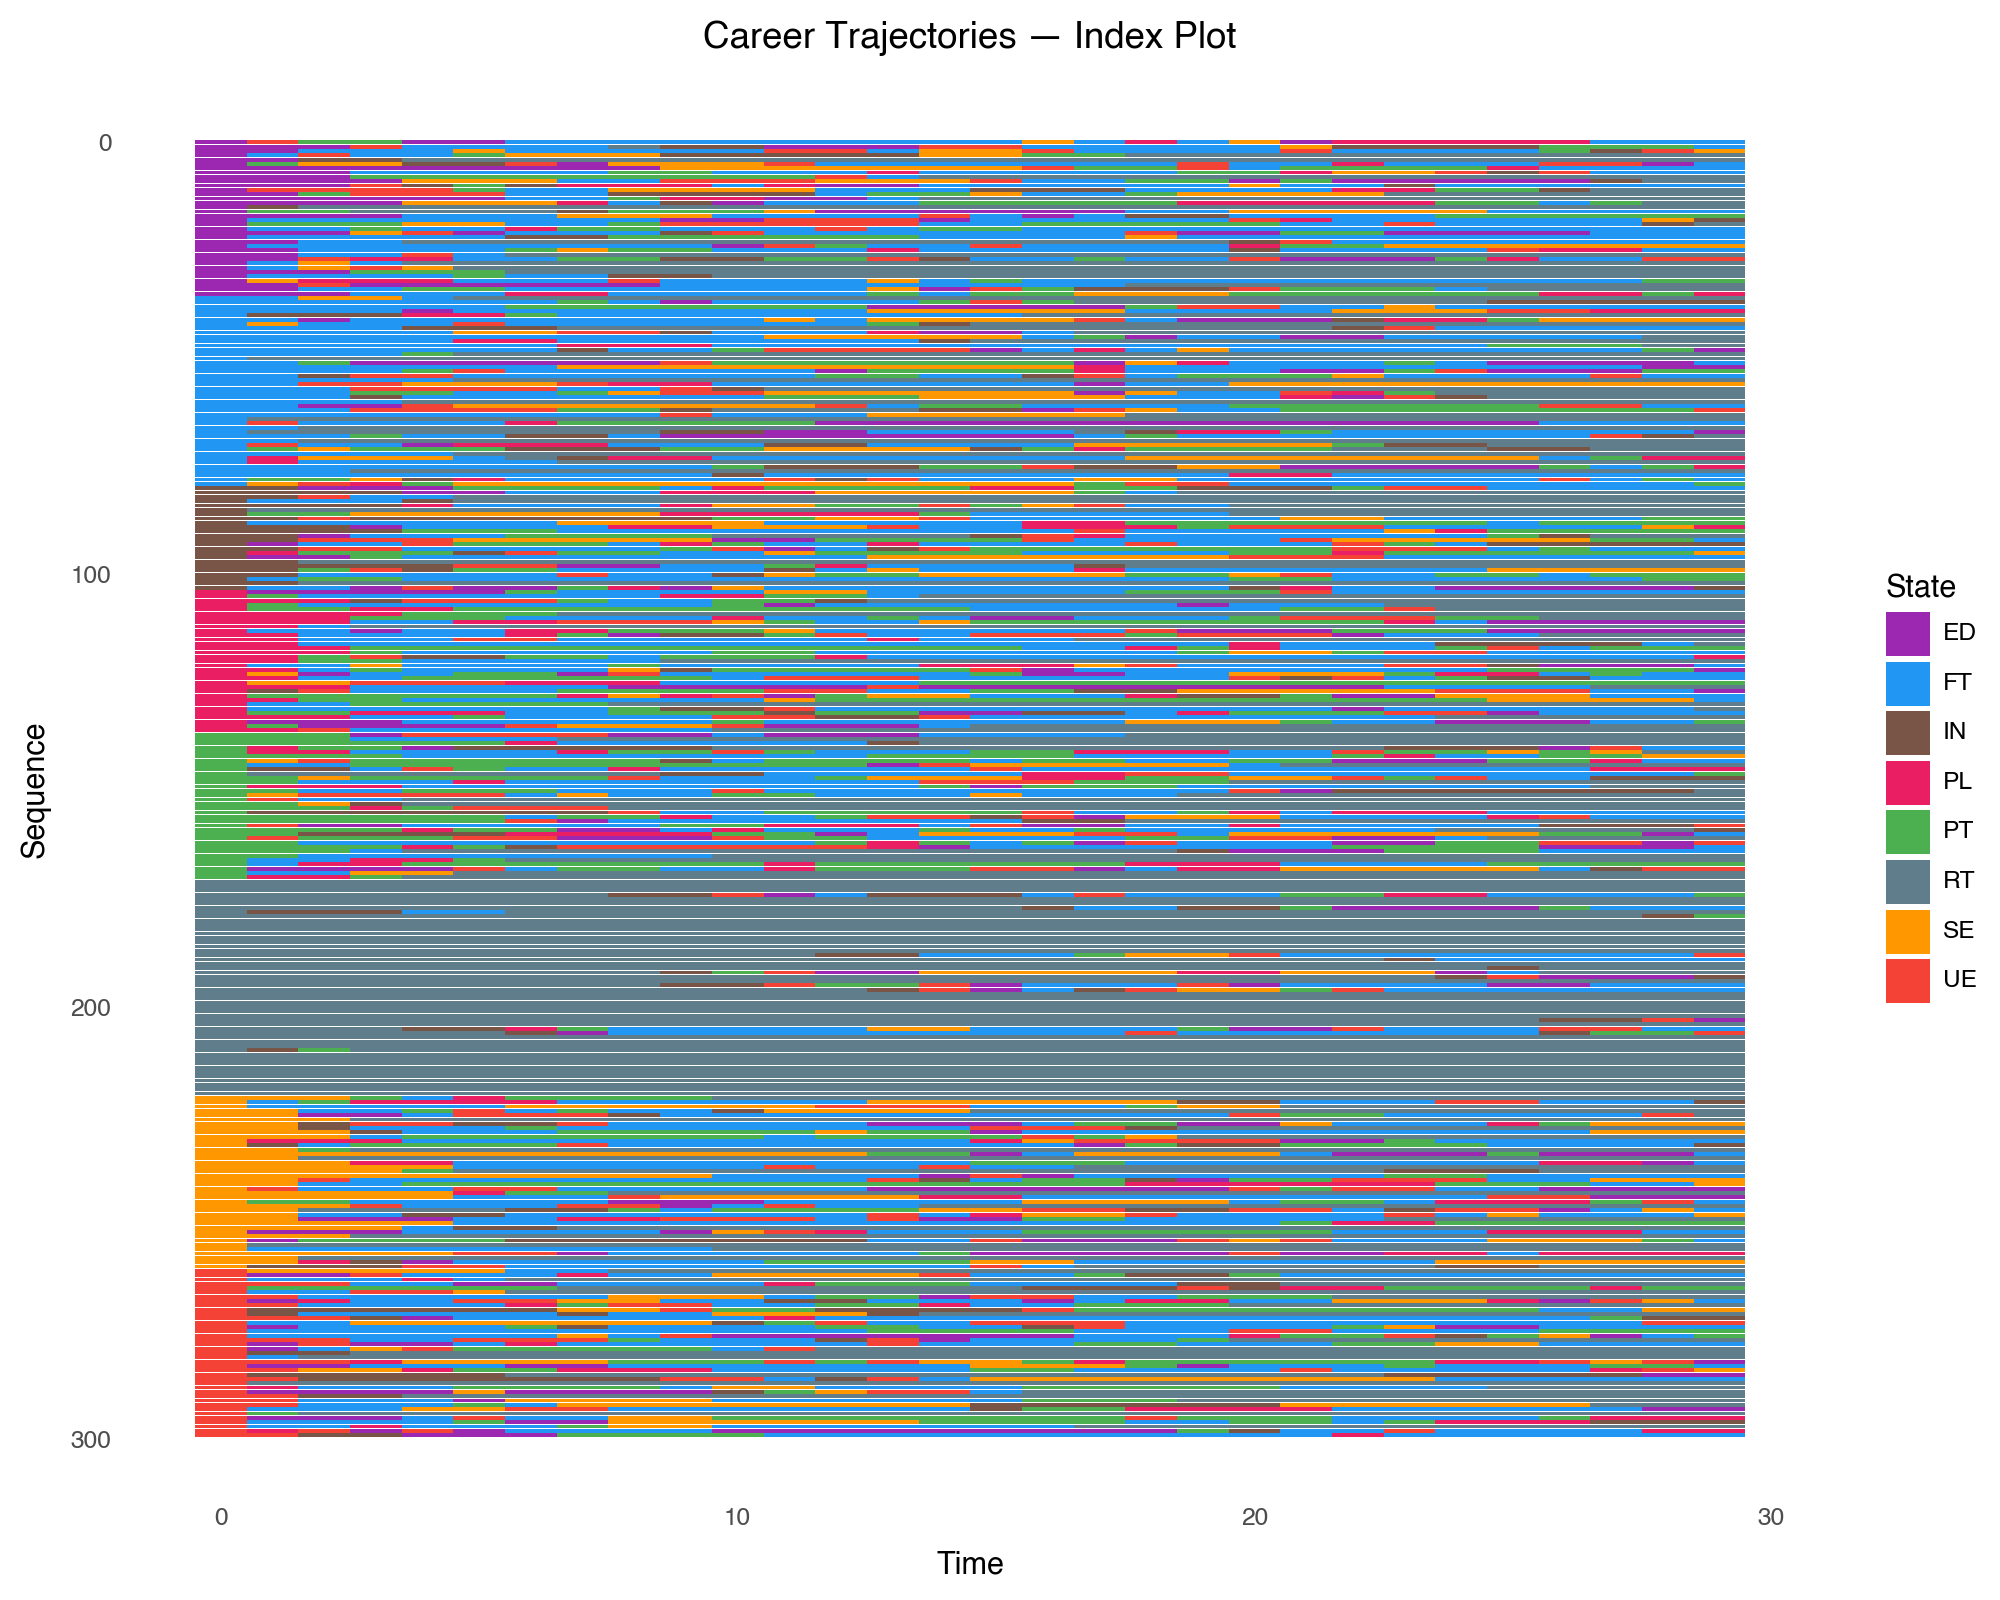

In [47]:
# 1. Index plot — each sequence as a coloured horizontal bar
index_plot(career_seq, title="Career Trajectories — Index Plot", sort_by="from.start")

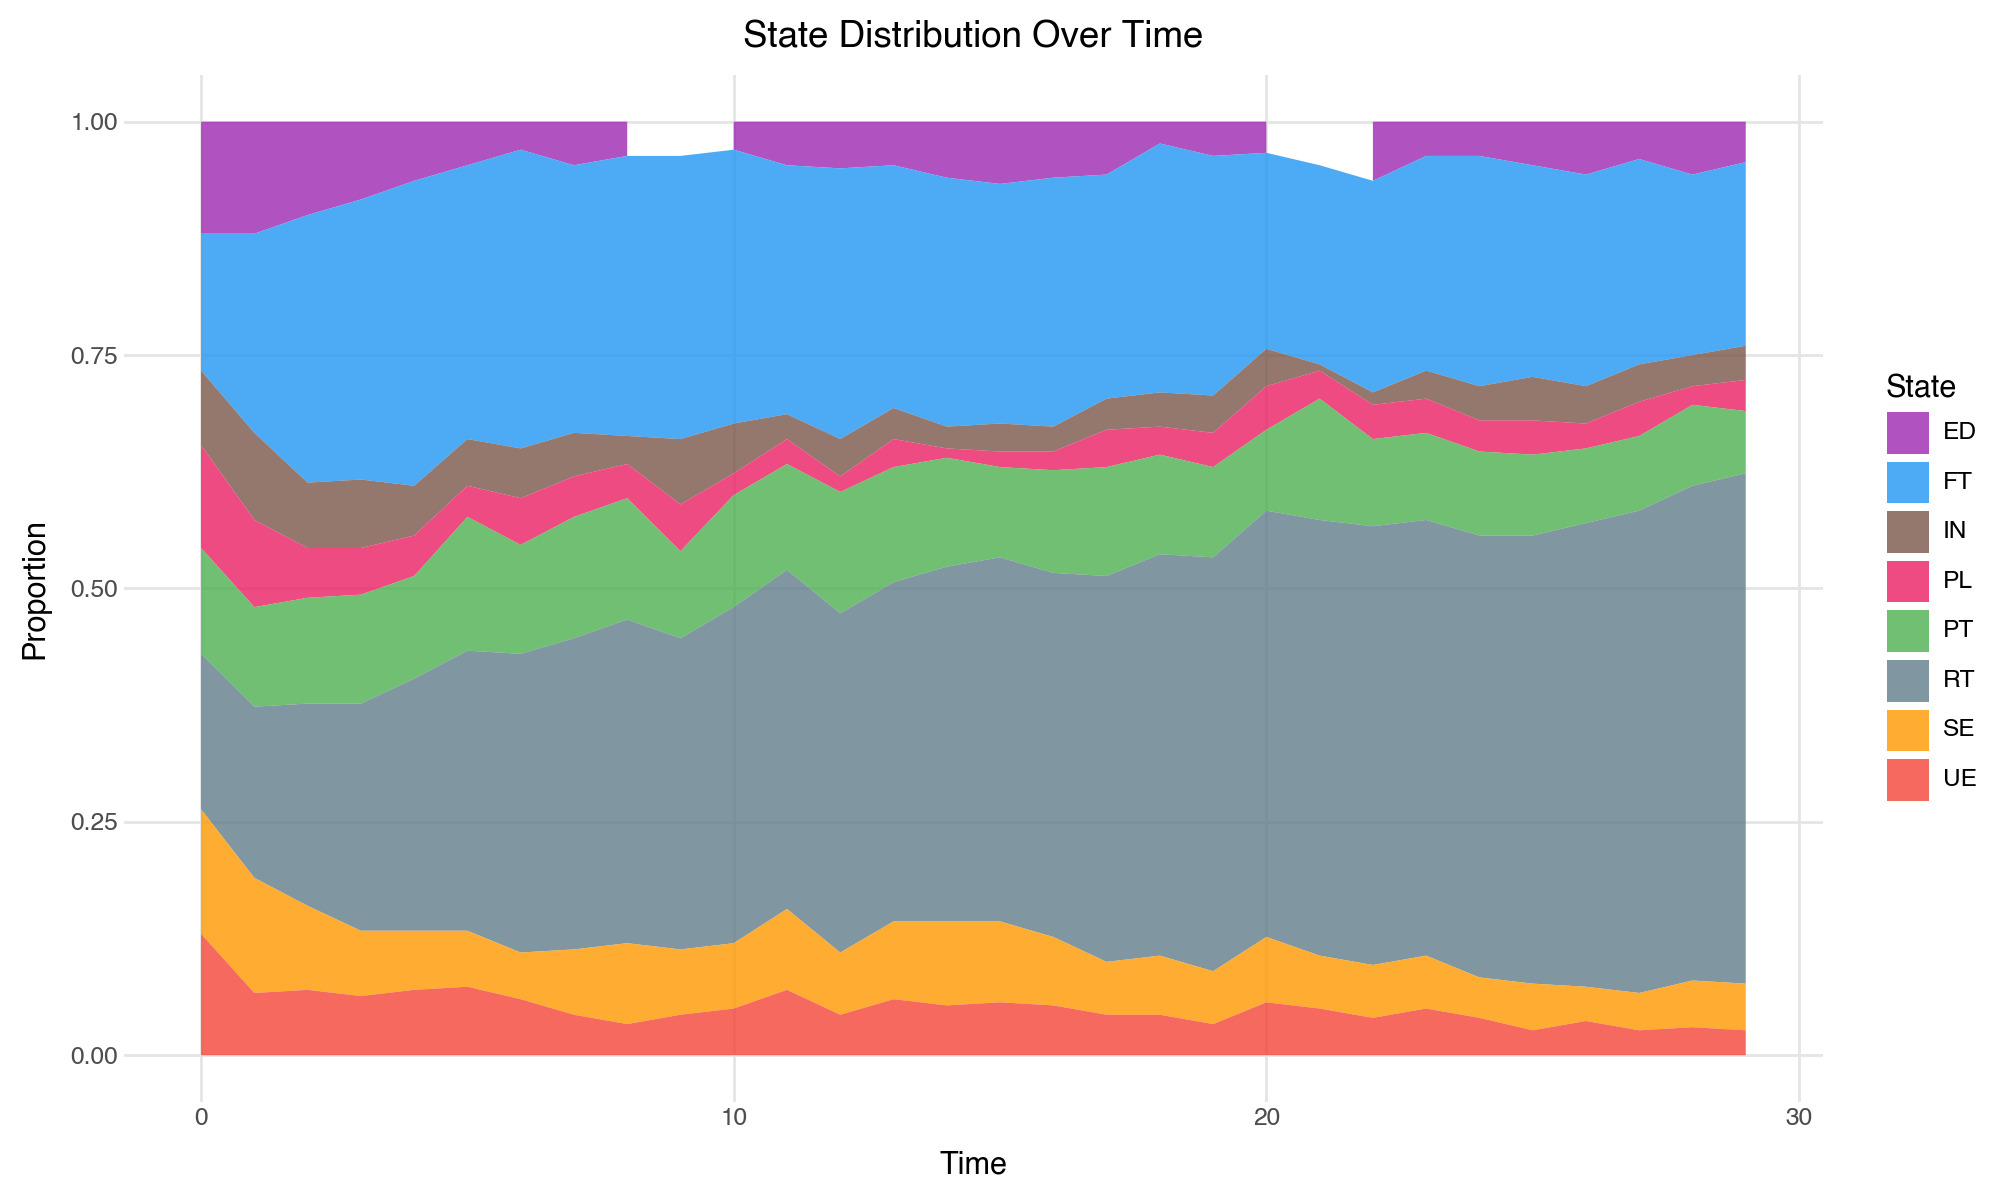

In [48]:
# 2. Distribution plot — state proportions over time (stacked area)
distribution_plot(career_seq, title="State Distribution Over Time")

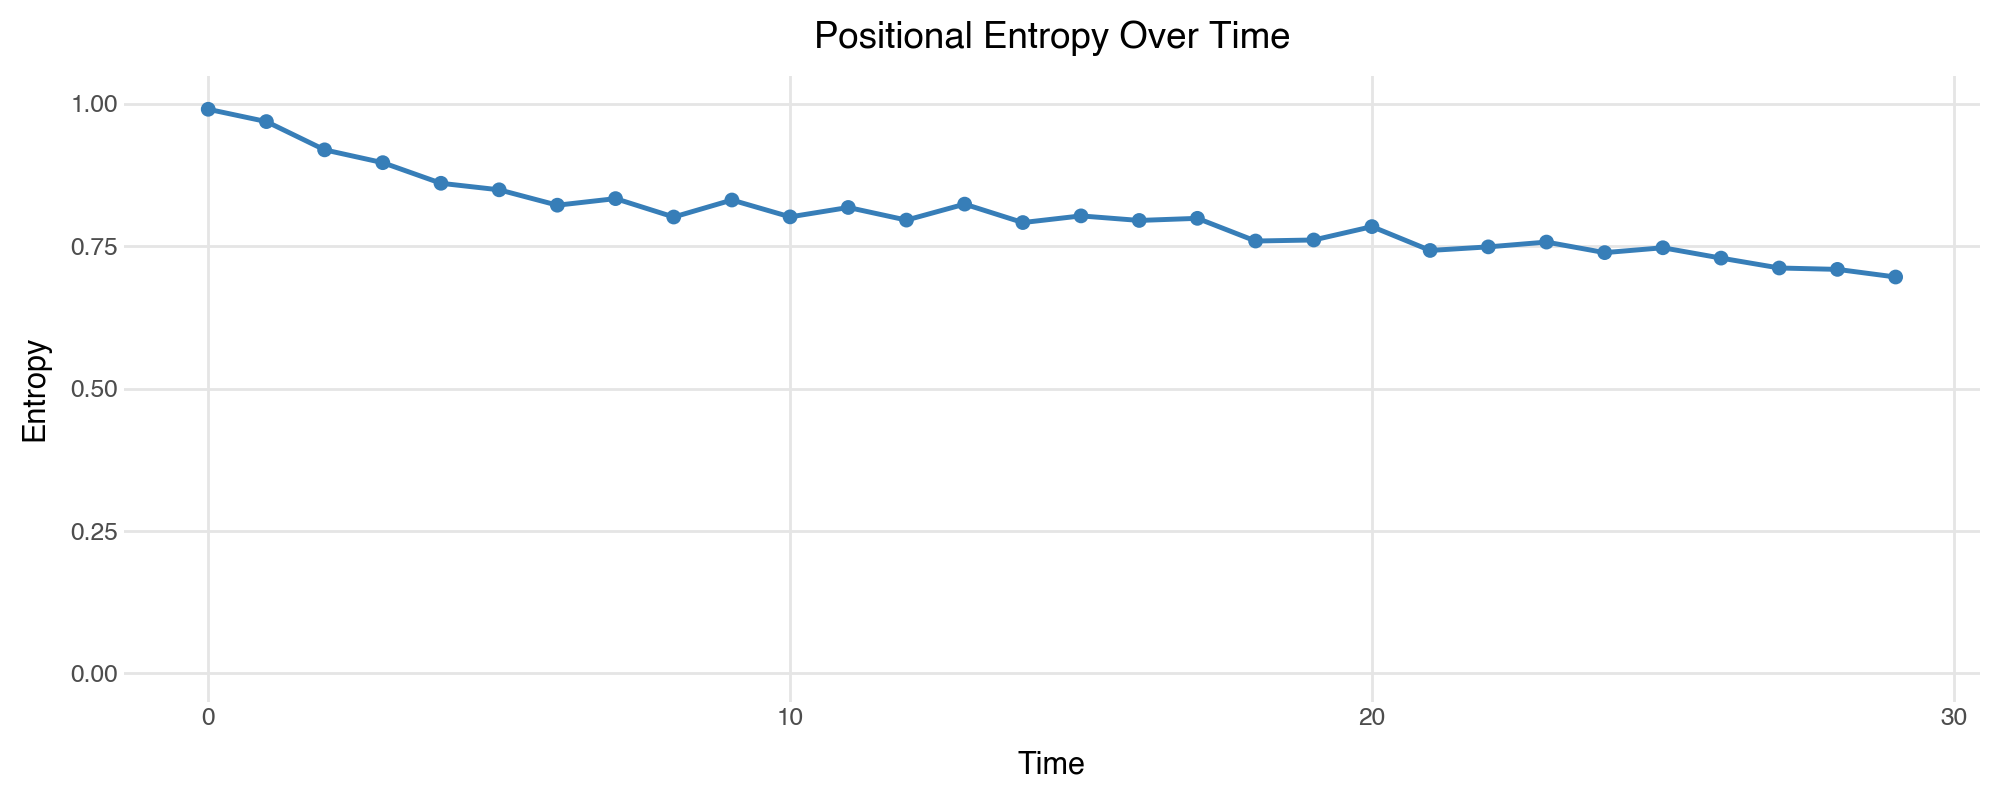

In [49]:
# 3. Entropy plot — positional entropy over time
entropy_plot(career_seq, title="Positional Entropy Over Time")

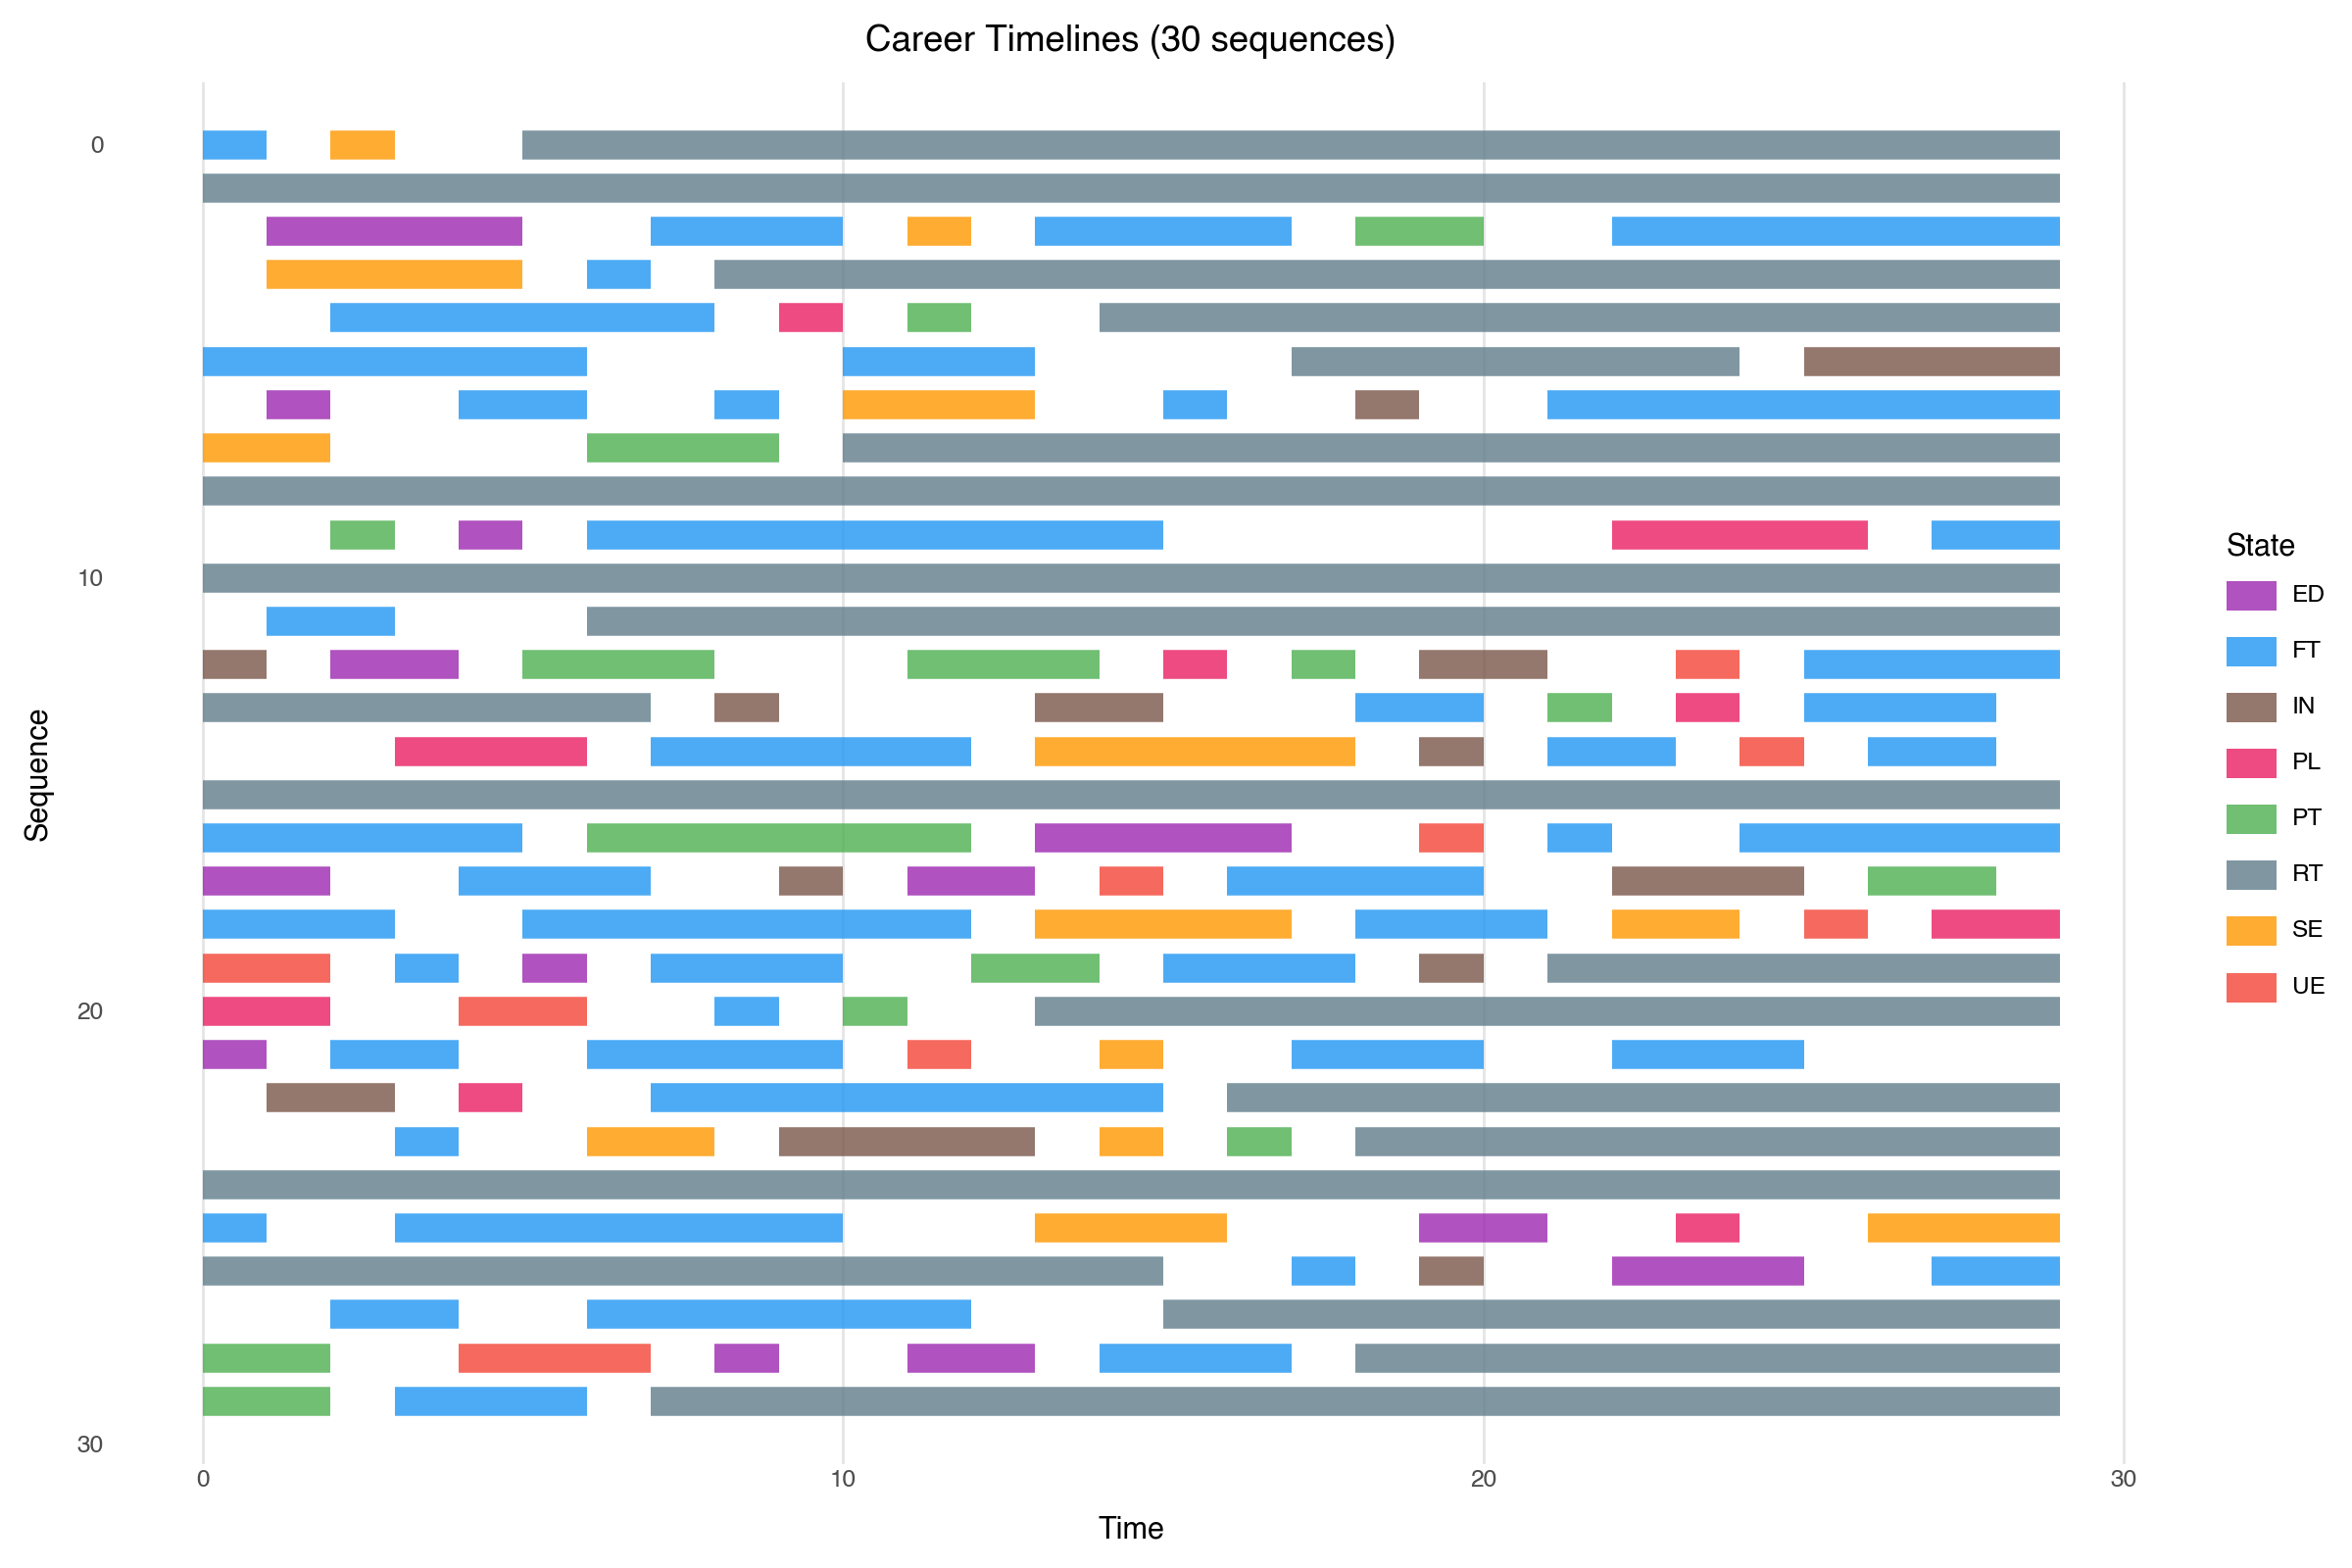

In [50]:
# 4. Timeline plot — Gantt-chart style view of spells
timeline_plot(career_seq, max_sequences=30, title="Career Timelines (30 sequences)")

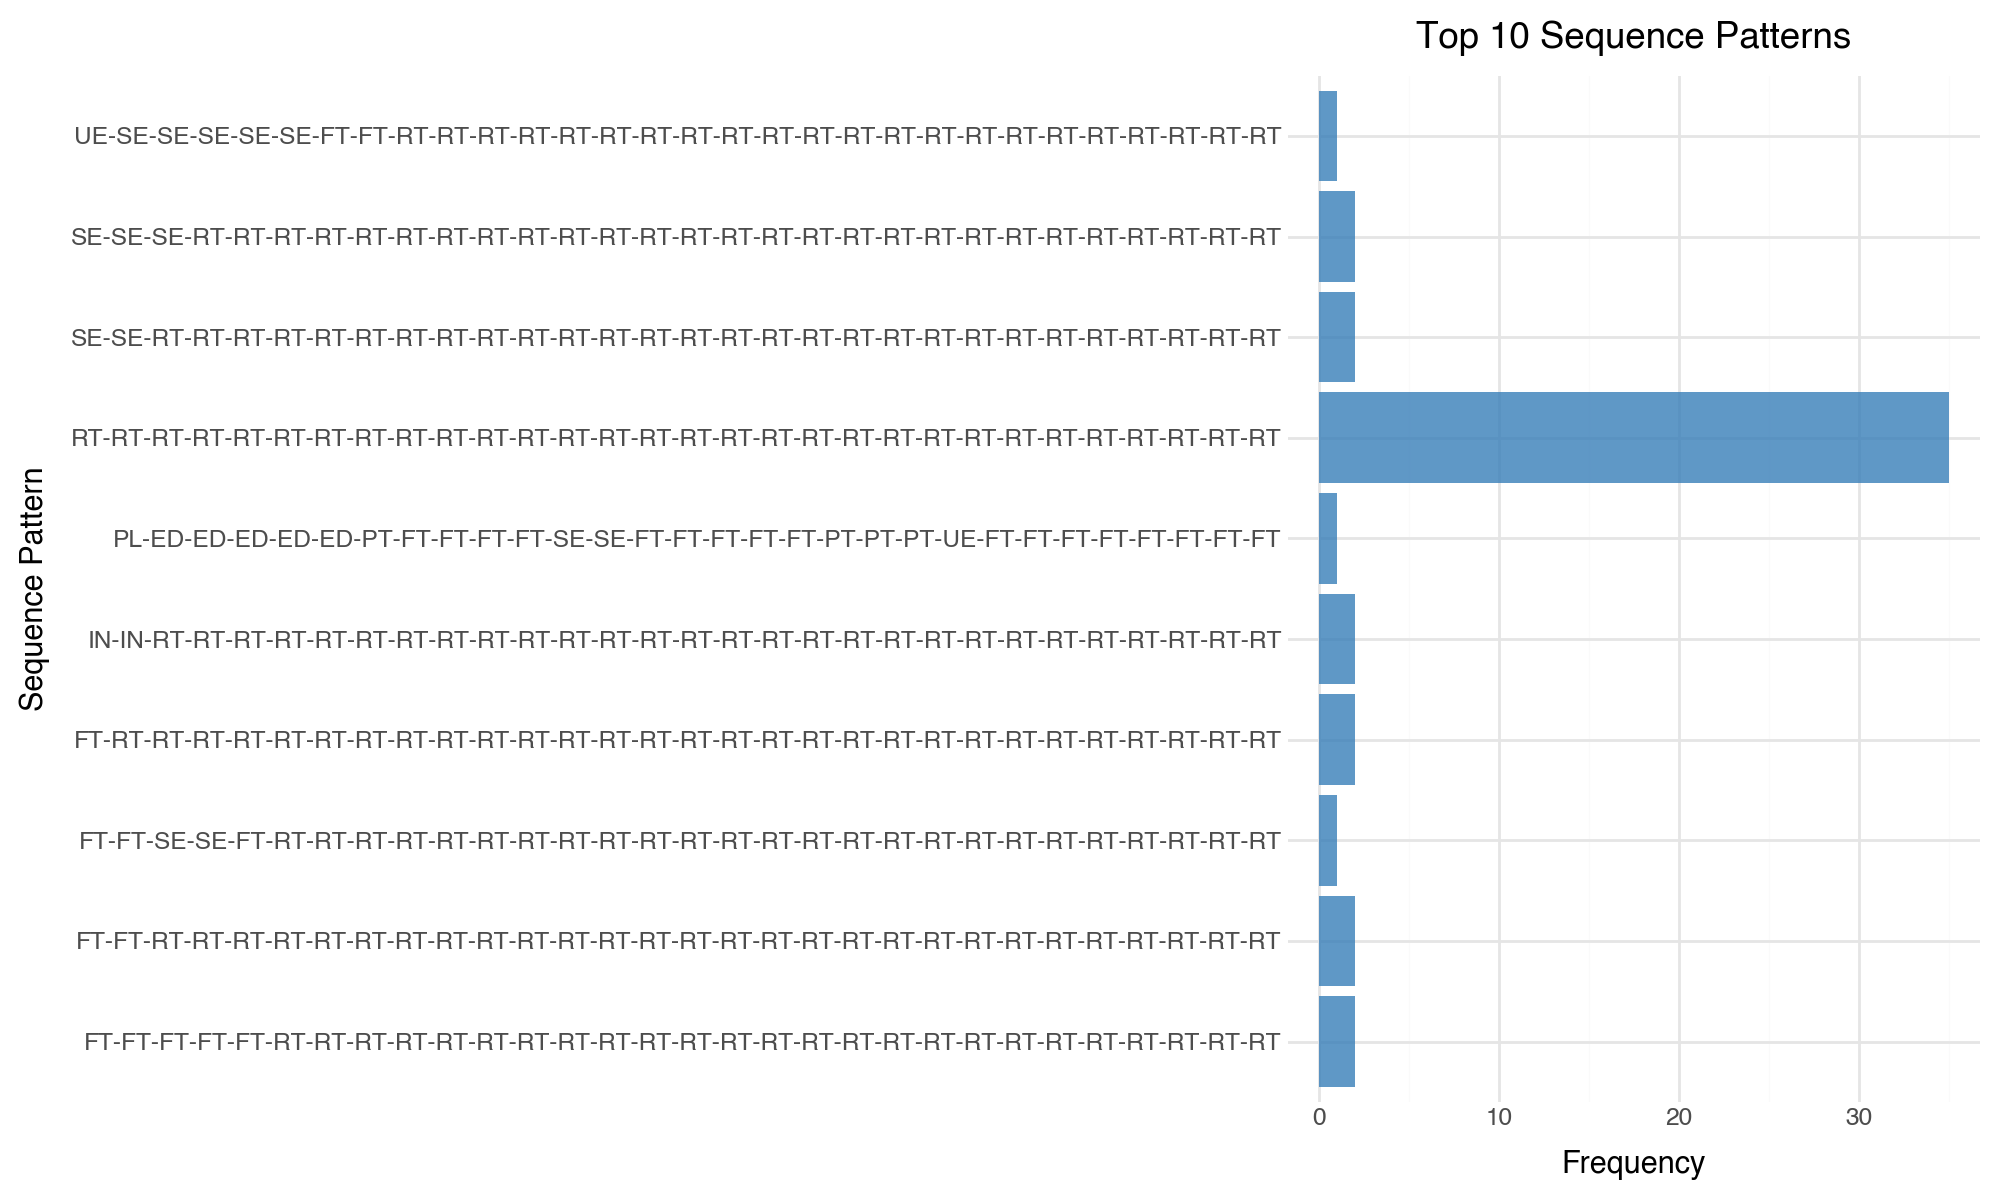

In [51]:
# 5. Frequency plot — most common sequence patterns
frequency_plot(career_seq, n_most_frequent=10, title="Top 10 Sequence Patterns")

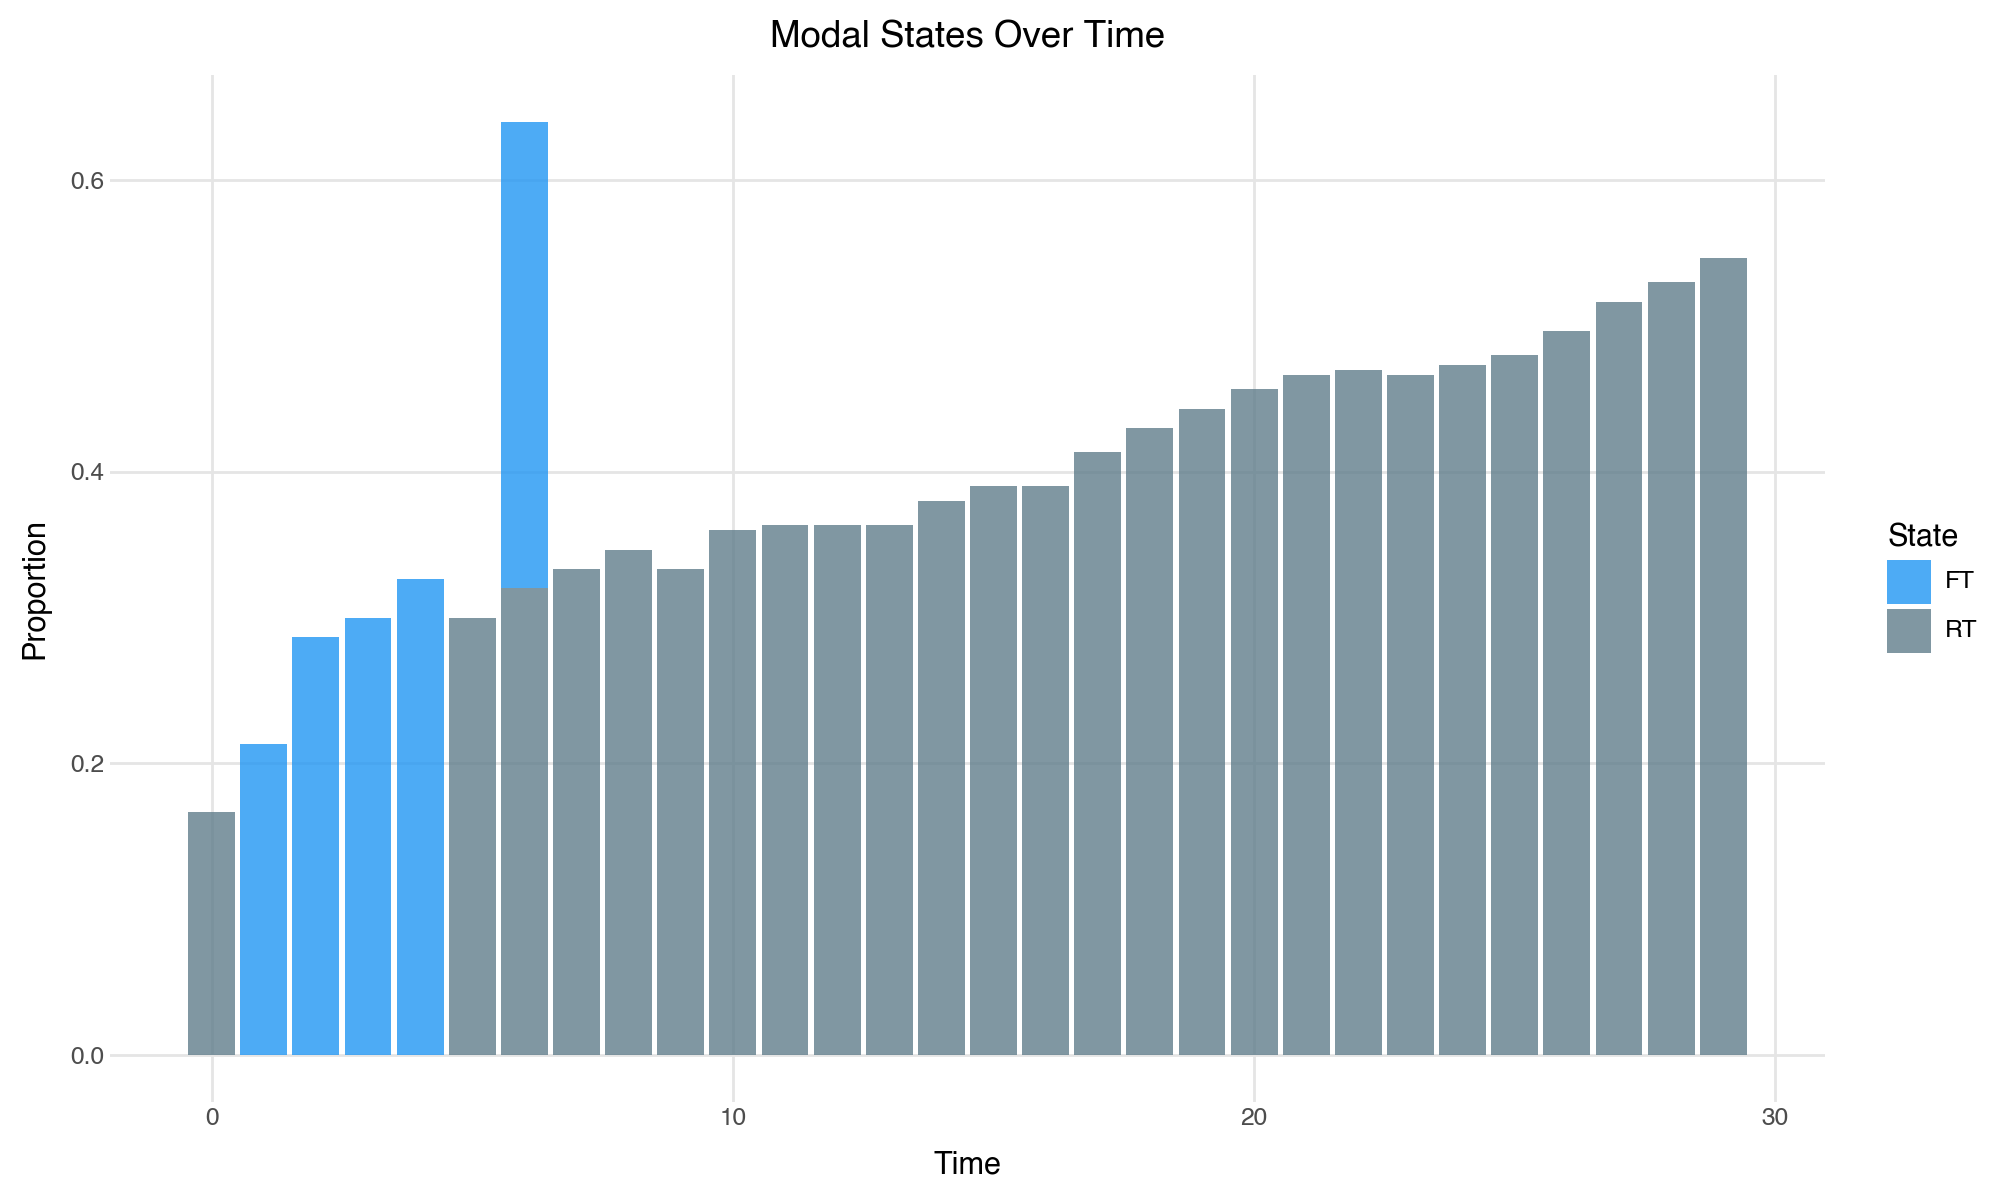

In [52]:
# 6. Modal state plot — most frequent state at each time position
modal_state_plot(career_seq, title="Modal States Over Time")

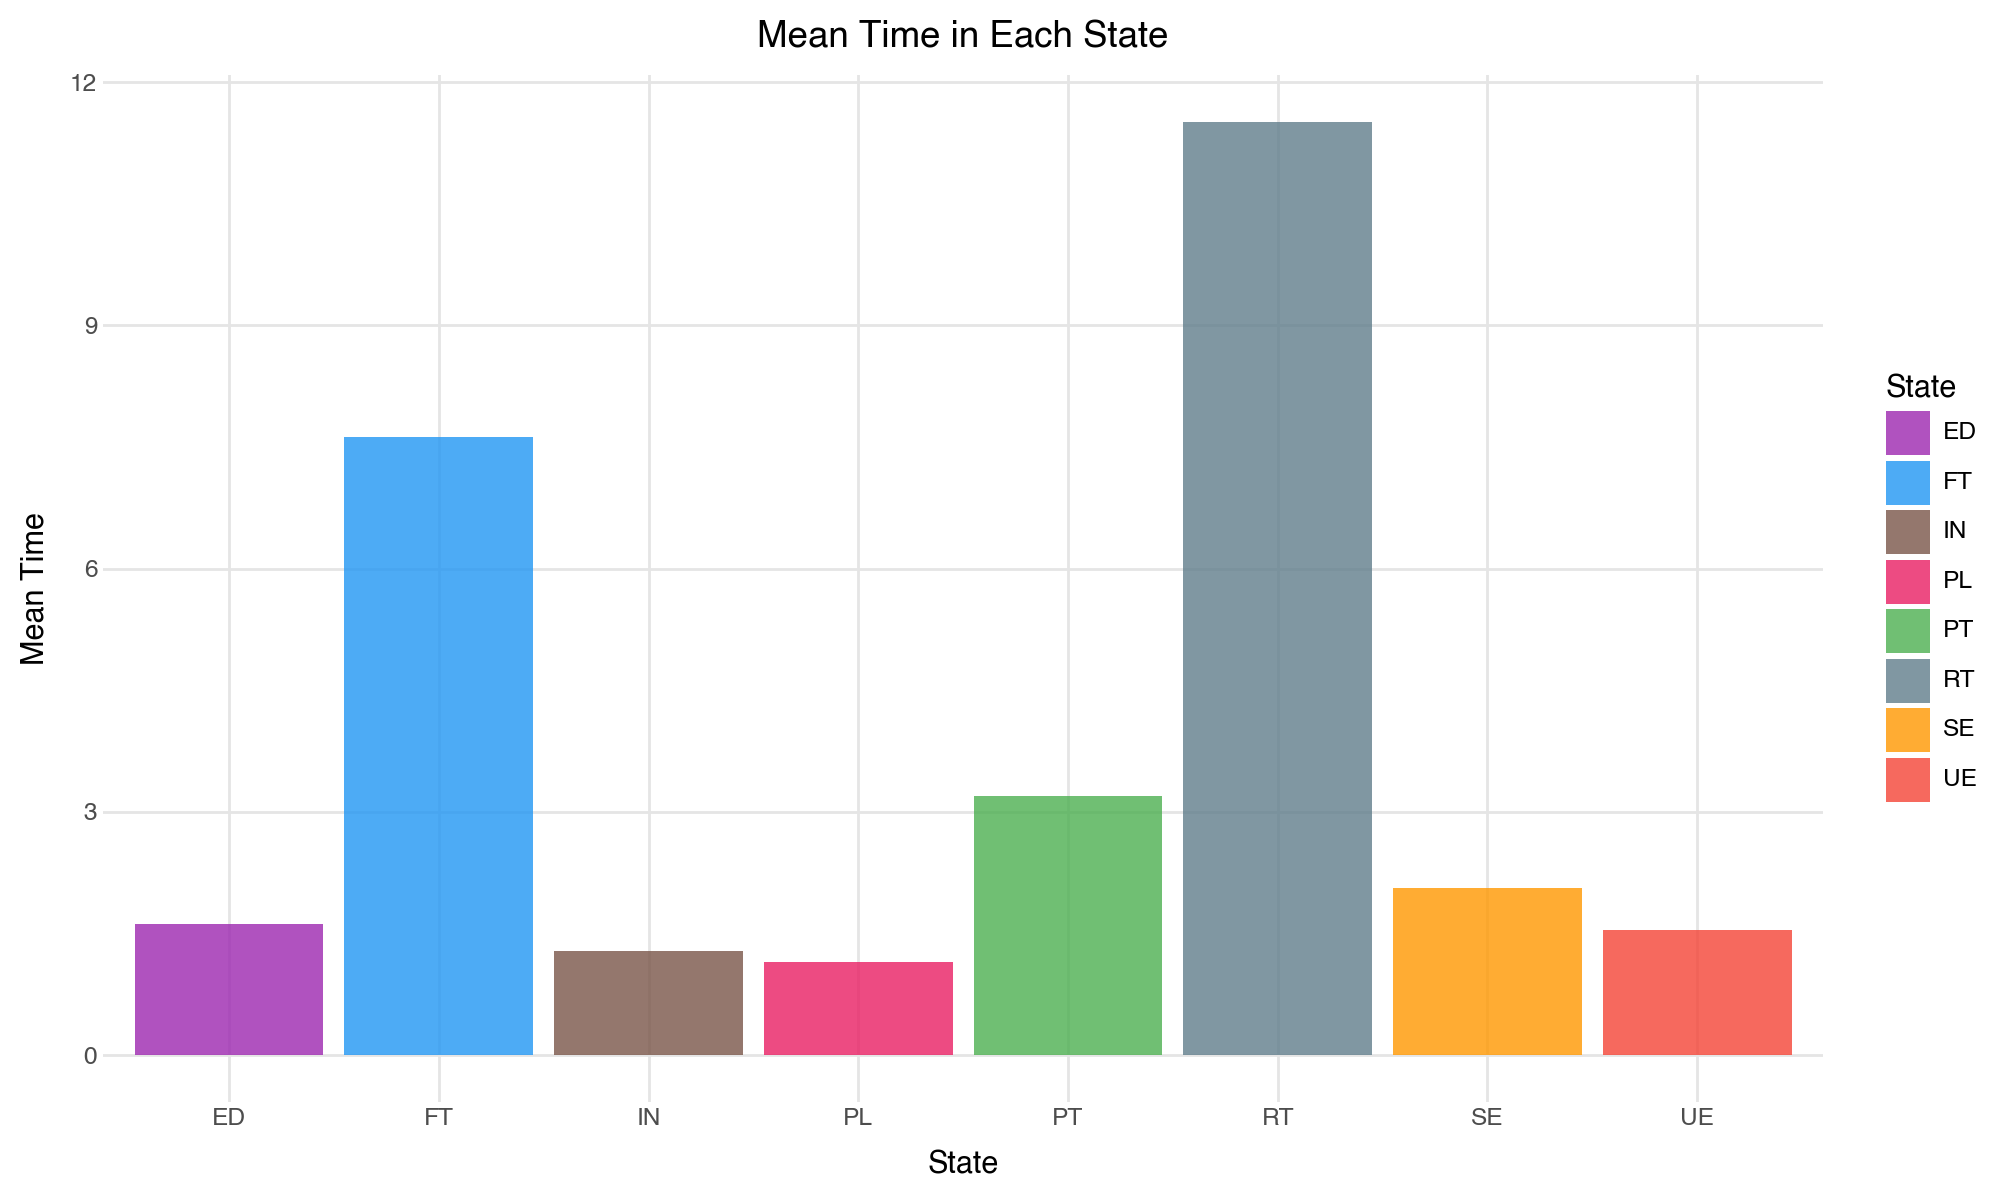

In [53]:
# 7. Mean time plot — average time spent in each state
mean_time_plot(career_seq, title="Mean Time in Each State")

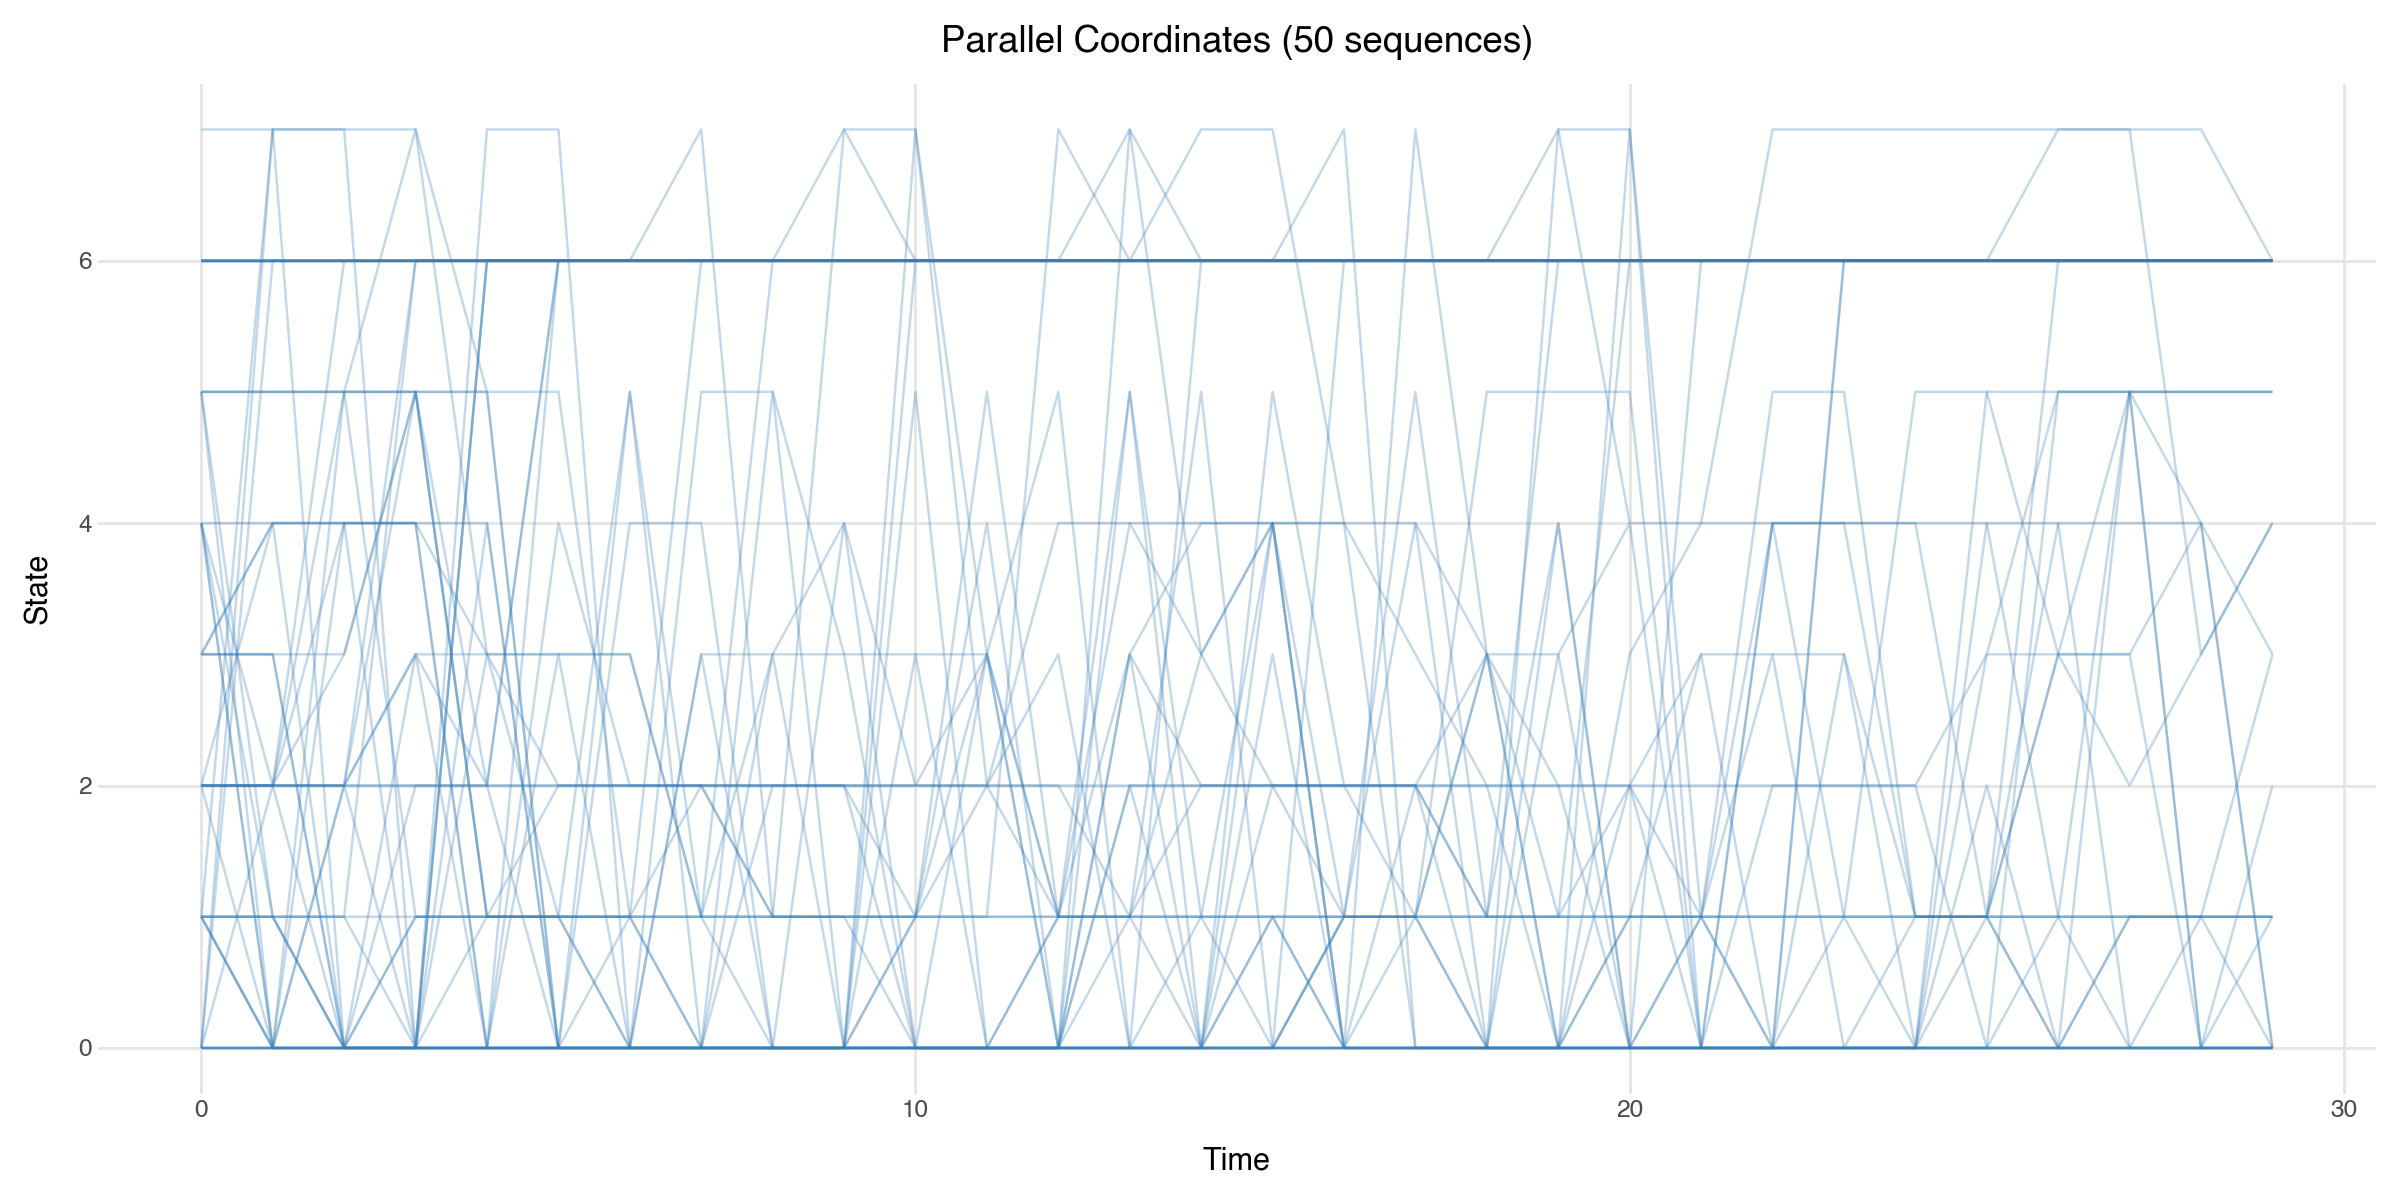

In [54]:
# 8. Parallel coordinate plot — individual trajectories as lines
parallel_coordinate_plot(career_seq, max_sequences=50, alpha=0.3, title="Parallel Coordinates (50 sequences)", seed=42)

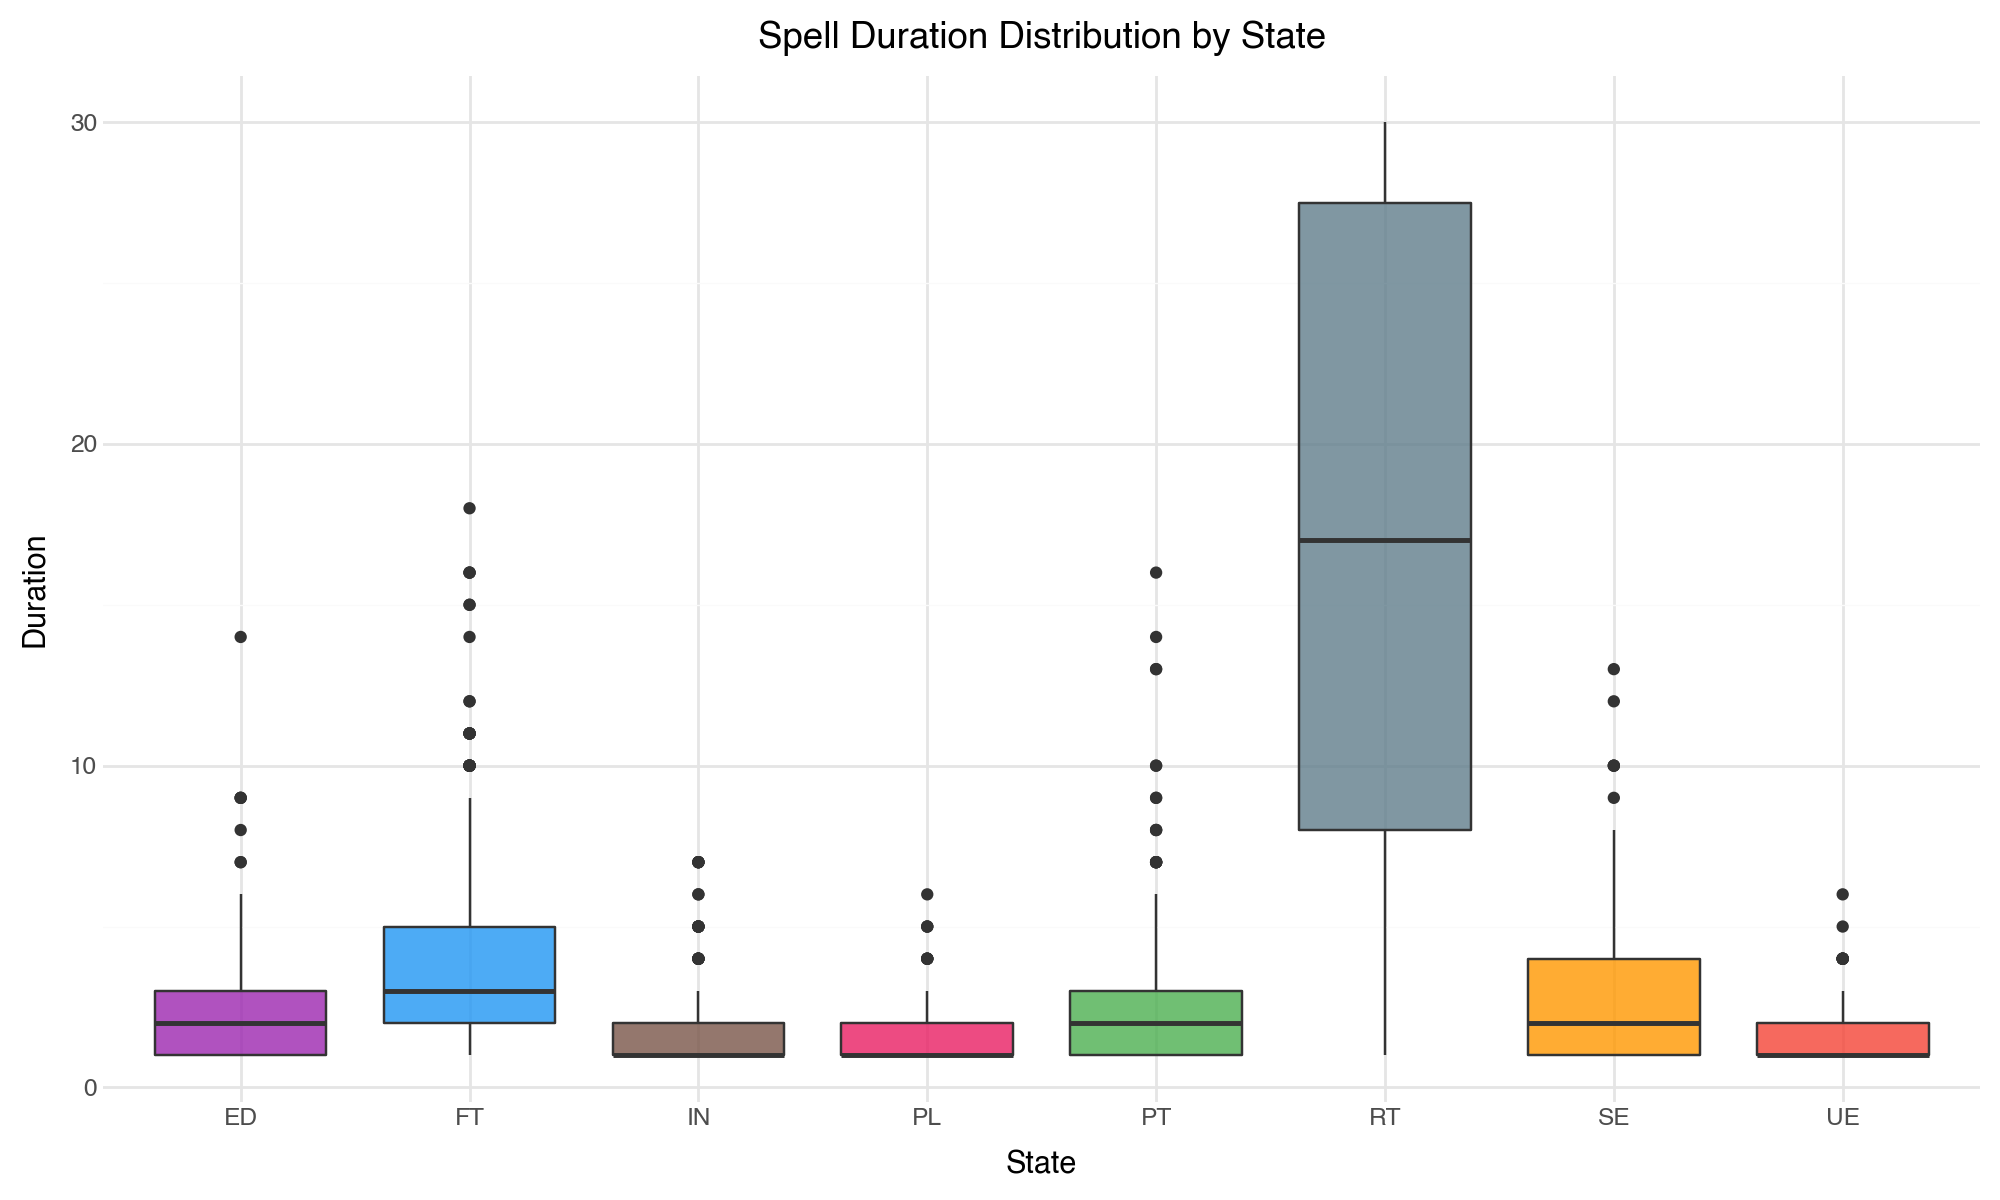

In [55]:
# 9. Spell duration plot — boxplot of spell durations by state
spell_duration_plot(career_seq, title="Spell Duration Distribution by State")

## 7. Distance Metrics

yasqat implements **18 pairwise distance metrics** from the sequence analysis literature.
All operate on integer-encoded sequences (`np.ndarray`).

### 7.1 Pairwise Examples

We take two encoded career sequences and compute all 18 distances.

In [56]:
from yasqat.metrics import (
    optimal_matching_distance,
    hamming_distance,
    lcs_distance,
    lcp_distance,
    rlcp_distance,
    euclidean_distance,
    chi2_distance,
    dtw_distance,
    softdtw_distance,
    twed_distance,
    dhd_distance,
    omloc_distance,
    omspell_distance,
    omstran_distance,
    nms_distance,
    nmsmst_distance,
    svrspell_distance,
)
from yasqat.metrics.dhd import build_position_costs

# Pick two sequences with different career patterns
seq_a = career_pool.get_encoded_sequence(0)
seq_b = career_pool.get_encoded_sequence(1)
print(f"Sequence A (decoded): {career_pool.get_sequence(0)}")
print(f"Sequence B (decoded): {career_pool.get_sequence(1)}")

Sequence A (decoded): ['FT', 'FT', 'SE', 'SE', 'FT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT']
Sequence B (decoded): ['RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT', 'RT']


### 7.2 Edit-Distance Family

These metrics measure the cost of transforming one sequence into another via
insertions, deletions, and substitutions.

In [57]:
print(f"Optimal Matching (OM):         {optimal_matching_distance(seq_a, seq_b):.4f}")
print(f"OM (normalized):               {optimal_matching_distance(seq_a, seq_b, normalize=True):.4f}")
print(f"OM-loc (locality-sensitive):    {omloc_distance(seq_a, seq_b):.4f}")
print(f"OM-spell (spell-length aware):  {omspell_distance(seq_a, seq_b):.4f}")
print(f"OM-stran (transition-weighted): {omstran_distance(seq_a, seq_b):.4f}")

Optimal Matching (OM):         10.0000
OM (normalized):               0.3333
OM-loc (locality-sensitive):    10.0000
OM-spell (spell-length aware):  1.3979
OM-stran (transition-weighted): 10.0000


### 7.3 Subsequence & Prefix Metrics

In [58]:
print(f"LCS (Longest Common Subsequence): {lcs_distance(seq_a, seq_b):.4f}")
print(f"LCP (Longest Common Prefix):      {lcp_distance(seq_a, seq_b):.4f}")
print(f"RLCP (Reversed LCP):              {rlcp_distance(seq_a, seq_b):.4f}")

LCS (Longest Common Subsequence): 10.0000
LCP (Longest Common Prefix):      60.0000
RLCP (Reversed LCP):              10.0000


### 7.4 Time-Warping Metrics

These metrics allow flexible temporal alignment between sequences.

In [59]:
print(f"DTW (Dynamic Time Warping):    {dtw_distance(seq_a, seq_b):.4f}")
print(f"SoftDTW (differentiable DTW):  {softdtw_distance(seq_a, seq_b, gamma=1.0):.4f}")
print(f"TWED (Time Warp Edit Dist.):   {twed_distance(seq_a, seq_b, nu=0.001, lmbda=1.0):.4f}")

DTW (Dynamic Time Warping):    5.0000
SoftDTW (differentiable DTW):  -41.9777
TWED (Time Warp Edit Dist.):   10.0000


### 7.5 Position & Distribution Metrics

These compare sequences position-by-position or via state distributions.

In [60]:
n_states = career_alphabet.n_states

print(f"Hamming:                       {hamming_distance(seq_a, seq_b):.4f}")

# DHD requires position-specific costs (built from the pool)
pos_costs = build_position_costs(career_pool)
print(f"DHD (Dynamic Hamming):         {dhd_distance(seq_a, seq_b, pos_costs):.4f}")

print(f"Chi-squared:                   {chi2_distance(seq_a, seq_b, n_states=n_states):.4f}")
print(f"Euclidean:                     {euclidean_distance(seq_a, seq_b, n_states=n_states):.4f}")
print(f"NMS (Normalised Match Sim.):   {nms_distance(seq_a, seq_b):.4f}")
print(f"NMS-MST:                       {nmsmst_distance(seq_a, seq_b):.4f}")
print(f"SVRspell:                      {svrspell_distance(seq_a, seq_b, n_states=n_states):.4f}")

Hamming:                       5.0000
DHD (Dynamic Hamming):         4.2468
Chi-squared:                   2.7273
Euclidean:                     0.2055
NMS (Normalised Match Sim.):   0.9739
NMS-MST:                       0.9108
SVRspell:                      10.0000


### 7.6 Distance Matrix Computation

`SequencePool.compute_distances()` computes the full pairwise distance matrix.
We use a 50-sequence subset for speed.

In [61]:
# Subsample 50 sequences for distance matrix computation
career_pool_50 = career_pool.sample(50, seed=42)
print(f"Subset pool size: {len(career_pool_50)}")

# Compute OM distance matrix (returns np.ndarray)
dist_matrix = career_pool_50.compute_distances(method="om")
print(f"Distance matrix shape: {dist_matrix.shape}")
print(f"Distance matrix dtype: {dist_matrix.dtype}")
print(f"Min distance: {dist_matrix[dist_matrix > 0].min():.4f}")
print(f"Max distance: {dist_matrix.max():.4f}")
print(f"Mean distance: {dist_matrix[np.triu_indices_from(dist_matrix, k=1)].mean():.4f}")

Subset pool size: 50
Distance matrix shape: (50, 50)
Distance matrix dtype: float64
Min distance: 2.0000
Max distance: 60.0000
Mean distance: 37.9118


## 8. Clustering

yasqat provides three clustering algorithms for distance matrices,
plus quality metrics and representative extraction.

### 8.1 PAM (Partitioning Around Medoids)

PAM is k-medoids clustering — like k-means but uses actual data points as centres,
making it ideal for distance matrices.

In [62]:
from yasqat.clustering import pam_clustering

pam_result = pam_clustering(dist_matrix, n_clusters=3, random_state=42)
print(f"PAM clusters: {pam_result.n_clusters}")
print(f"Cluster sizes: {pam_result.cluster_sizes()}")
print(f"Medoid indices: {pam_result.medoid_indices}")
print(f"Total cost: {pam_result.total_cost:.4f}")
print(f"Iterations: {pam_result.n_iterations}")
print(f"\nCluster assignments (first 10): {pam_result.labels[:10]}")

PAM clusters: 3
Cluster sizes: {np.int32(0): np.int64(11), np.int32(1): np.int64(20), np.int32(2): np.int64(19)}
Medoid indices: [ 8 20 17]
Total cost: 996.0000
Iterations: 4

Cluster assignments (first 10): [1 0 0 2 2 1 2 2 0 2]


### 8.2 Hierarchical Clustering

Agglomerative clustering with four linkage methods.

In [63]:
from yasqat.clustering import hierarchical_clustering

for method in ["ward", "complete", "average", "single"]:
    hc = hierarchical_clustering(dist_matrix, n_clusters=3, method=method)
    sizes = hc.cluster_sizes()
    print(f"{method:>8s} linkage: cluster sizes = {sizes}")

    ward linkage: cluster sizes = {np.int32(0): np.int64(21), np.int32(1): np.int64(13), np.int32(2): np.int64(16)}
complete linkage: cluster sizes = {np.int32(0): np.int64(16), np.int32(1): np.int64(25), np.int32(2): np.int64(9)}
 average linkage: cluster sizes = {np.int32(0): np.int64(28), np.int32(1): np.int64(2), np.int32(2): np.int64(20)}
  single linkage: cluster sizes = {np.int32(0): np.int64(48), np.int32(1): np.int64(1), np.int32(2): np.int64(1)}


### 8.3 CLARA (Clustering LARge Applications)

CLARA extends PAM to large datasets by clustering random subsamples
and keeping the best result.

In [64]:
from yasqat.clustering import clara_clustering

clara_result = clara_clustering(dist_matrix, n_clusters=3, n_samples=5, random_state=42)
print(f"CLARA clusters: {clara_result.n_clusters}")
print(f"Cluster sizes: {clara_result.cluster_sizes()}")
print(f"Total cost: {clara_result.total_cost:.4f}")
print(f"Best sample cost: {clara_result.best_sample_cost:.4f}")

CLARA clusters: 3
Cluster sizes: {np.int32(0): np.int64(11), np.int32(1): np.int64(20), np.int32(2): np.int64(19)}
Total cost: 996.0000
Best sample cost: 934.0000


### 8.4 Cluster Quality Metrics

Four quality metrics assess how well the clustering captures the distance structure:
- **ASW** (Average Silhouette Width): [-1, 1], higher is better
- **PBC** (Point Biserial Correlation): correlation between distances and cluster membership
- **HG** (Hubert's Gamma): rank correlation of distances vs. cluster indicators
- **R²**: proportion of variance explained

In [65]:
from yasqat.clustering import silhouette_score, silhouette_scores, cluster_quality, distance_to_center

# Silhouette score (average)
asw = silhouette_score(dist_matrix, pam_result.labels)
print(f"Average Silhouette Width: {asw:.4f}")

# Per-sample silhouette scores
sil_scores = silhouette_scores(dist_matrix, pam_result.labels)
print(f"Silhouette scores (first 10): {np.round(sil_scores[:10], 3)}")

# Full quality report
quality = cluster_quality(dist_matrix, pam_result.labels)
print(f"\nCluster quality report:")
for metric, value in quality.items():
    print(f"  {metric}: {value:.4f}")

# Distance to cluster center (medoid)
d2c = distance_to_center(dist_matrix, pam_result.labels)
print(f"\nDistance to center (first 10): {np.round(d2c[:10], 3)}")

Average Silhouette Width: 0.3004
Silhouette scores (first 10): [ 0.296 -0.276 -0.132  0.741  0.331  0.074  0.184  0.554  0.216  0.741]

Cluster quality report:
  ASW: 0.3004
  PBC: -0.6345
  HG: 0.6345
  R2: 0.5232

Distance to center (first 10): [30.316 32.    32.    11.222 26.889 31.474 24.333 15.667 27.4   11.222]


### 8.5 Optimal k Selection

`pam_range` evaluates PAM clustering across a range of k values
and returns quality metrics for each.

In [66]:
from yasqat.clustering import pam_range

k_results = pam_range(dist_matrix, k_range=range(2, 6))
print("PAM range results:")
for k, metrics in sorted(k_results.items()):
    print(f"  k={k}: ASW={metrics['ASW']:.4f}, PBC={metrics['PBC']:.4f}, HG={metrics['HG']:.4f}, R2={metrics['R2']:.4f}")

PAM range results:
  k=2: ASW=0.3970, PBC=-0.6906, HG=0.6906, R2=0.4579
  k=3: ASW=0.3004, PBC=-0.6345, HG=0.6345, R2=0.5232
  k=4: ASW=0.3071, PBC=-0.6384, HG=0.6384, R2=0.6145
  k=5: ASW=0.3473, PBC=-0.6620, HG=0.6620, R2=0.6759


### 8.6 Representative Sequence Extraction

Extract representative sequences using three strategies:
- **centrality**: sequences closest to the overall centre
- **frequency**: most frequently occurring patterns
- **density**: sequences in the densest regions

In [67]:
from yasqat.clustering import extract_representatives

for strategy in ["centrality", "frequency", "density"]:
    reps = extract_representatives(dist_matrix, n_representatives=3, strategy=strategy, labels=pam_result.labels)
    print(f"{strategy:>10s}: indices={reps.indices}, scores={np.round(reps.scores, 3)}")

centrality: indices=[ 8 20 17], scores=[274. 532. 190.]
 frequency: indices=[11 20 26], scores=[ 8. 16. 14.]
   density: indices=[ 8 20 17], scores=[ 8.17  13.93  13.306]


## 9. Frequent Subsequence Mining

Extract frequently occurring subsequences from the career data.
This reveals common career patterns (e.g., FT→UE→FT return-to-work patterns).

In [68]:
from yasqat.statistics import frequent_subsequences

patterns = frequent_subsequences(career_pool, min_support=0.1, max_length=3)
print(f"Found {len(patterns)} frequent subsequences (support >= 10%, max length 3)")
print("\nTop 20 by support:")
for p in sorted(patterns, key=lambda x: -x.support)[:20]:
    print(f"  {' → '.join(p.pattern):30s}  support={p.support:4d}  ({p.proportion:.1%})")

Found 347 frequent subsequences (support >= 10%, max length 3)

Top 20 by support:
  FT                              support= 235  (78.3%)
  FT → FT                         support= 223  (74.3%)
  FT → FT → FT                    support= 207  (69.0%)
  PT                              support= 200  (66.7%)
  RT                              support= 190  (63.3%)
  UE                              support= 183  (61.0%)
  RT → RT                         support= 182  (60.7%)
  RT → RT → RT                    support= 177  (59.0%)
  PT → FT                         support= 169  (56.3%)
  FT → PT                         support= 164  (54.7%)
  UE → FT                         support= 162  (54.0%)
  PT → PT                         support= 156  (52.0%)
  SE                              support= 153  (51.0%)
  FT → FT → PT                    support= 152  (50.7%)
  PT → FT → FT                    support= 152  (50.7%)
  UE → FT → FT                    support= 150  (50.0%)
  IN                 

## 10. Discrepancy Analysis & Dissimilarity Trees

Discrepancy analysis tests whether groups of sequences differ significantly.
It decomposes the total sum-of-squares of a distance matrix into between-group
and within-group components (analogous to MANOVA for sequences).

### 10.1 Discrepancy Analysis

Test whether career trajectories differ between the 3 cohorts.

In [69]:
from yasqat.statistics import discrepancy_analysis

# Use the 50-sequence subset (aligned with dist_matrix)
cohort_50 = cohort_labels[career_pool_50.sequence_ids]

result = discrepancy_analysis(dist_matrix, cohort_50, n_permutations=999, random_state=42)
print(f"Pseudo-R²: {result.pseudo_r2:.4f}")
print(f"Pseudo-F:  {result.pseudo_f:.4f}")
print(f"p-value:   {result.p_value:.4f}")
print(f"Total SS:  {result.total_ss:.2f}")
print(f"Between SS: {result.between_ss:.2f}")
print(f"Within SS:  {result.within_ss:.2f}")

Pseudo-R²: 0.0415
Pseudo-F:  1.0174
p-value:   0.3670
Total SS:  40227.28
Between SS: 1669.37
Within SS:  38557.91


### 10.2 Multi-Factor Discrepancy

Test multiple grouping variables simultaneously.

In [70]:
from yasqat.statistics import multi_factor_discrepancy

gender_50 = gender_labels[career_pool_50.sequence_ids]

factors = {
    "cohort": cohort_50,
    "gender": gender_50,
}

multi_results = multi_factor_discrepancy(dist_matrix, factors, n_permutations=999, random_state=42)
for factor_name, res in multi_results.items():
    print(f"{factor_name:>8s}: R²={res.pseudo_r2:.4f}, F={res.pseudo_f:.4f}, p={res.p_value:.4f}")

  cohort: R²=0.0415, F=1.0174, p=0.3670
  gender: R²=0.0189, F=0.9228, p=0.3730


### 10.3 Dissimilarity Tree

A recursive partitioning method that finds the covariate splits
that best explain sequence dissimilarity.

In [71]:
from yasqat.statistics import dissimilarity_tree

# Build covariate matrix (numeric encoding)
covariates = np.column_stack([
    np.array([{"early": 0, "mid": 1, "late": 2}[c] for c in cohort_50]),
    np.array([{"M": 0, "F": 1}[g] for g in gender_50]),
])

tree_result = dissimilarity_tree(
    dist_matrix,
    covariates,
    covariate_names=["cohort", "gender"],
    max_depth=3,
    min_node_size=5,
    min_r2_gain=0.01,
)

print(f"Dissimilarity tree: {tree_result.n_leaves} leaves")
print(f"Root R²: {tree_result.root.pseudo_r2:.4f}")

# Print tree structure
def print_tree(node, indent=0):
    prefix = "  " * indent
    if node.split_variable is not None:
        print(f"{prefix}Split: {node.split_variable} <= {node.split_value} (R²={node.pseudo_r2:.4f}, n={len(node.indices)})")
        if node.left:
            print_tree(node.left, indent + 1)
        if node.right:
            print_tree(node.right, indent + 1)
    else:
        print(f"{prefix}Leaf (R²={node.pseudo_r2:.4f}, n={len(node.indices)})")

print("\nTree structure:")
print_tree(tree_result.root)

Dissimilarity tree: 6 leaves
Root R²: 0.0305

Tree structure:
Split: cohort <= 0.0 (R²=0.0305, n=50)
  Split: gender <= 0.0 (R²=0.0540, n=11)
    Leaf (R²=0.0000, n=4)
    Leaf (R²=0.0000, n=7)
  Split: gender <= 0.0 (R²=0.0274, n=39)
    Split: cohort <= 1.0 (R²=0.0898, n=20)
      Leaf (R²=0.0000, n=8)
      Leaf (R²=0.0000, n=12)
    Split: cohort <= 1.0 (R²=0.0742, n=19)
      Leaf (R²=0.0000, n=11)
      Leaf (R²=0.0000, n=8)


## 11. Filtering & Selection

yasqat provides **7 filter criteria** that can be combined with AND/OR logic.
Filters work on any `BaseSequence` (StateSequence, EventSequence, IntervalSequence).

### 11.1 Single Criteria

In [72]:
from yasqat.filters import (
    LengthCriterion,
    ContainsStateCriterion,
    StartsWithCriterion,
    PatternCriterion,
    TimeCriterion,
    QueryCriterion,
    filter_sequences,
)

# LengthCriterion — all sequences are length 30, so filter for exact length
lc = LengthCriterion(exact_length=30)
ids = lc.get_matching_ids(career_seq)
print(f"LengthCriterion(exact_length=30): {len(ids)} matches")

# ContainsStateCriterion — sequences that visit Retirement
cc = ContainsStateCriterion(states=["RT"])
ids = cc.get_matching_ids(career_seq)
print(f"ContainsStateCriterion(['RT']): {len(ids)} sequences visit Retirement")

# StartsWithCriterion — sequences starting with Education
sw = StartsWithCriterion(states=["ED"])
ids = sw.get_matching_ids(career_seq)
print(f"StartsWithCriterion(['ED']): {len(ids)} sequences start with Education")

# PatternCriterion — sequences containing the pattern FT→UE→FT
pc = PatternCriterion(pattern="FT,UE,FT", match_anywhere=True)
ids = pc.get_matching_ids(career_seq)
print(f"PatternCriterion('FT,UE,FT'): {len(ids)} sequences contain FT→UE→FT")

# TimeCriterion — sequences with events in a time range
tc = TimeCriterion(start_after=5, end_before=25)
ids = tc.get_matching_ids(career_seq)
print(f"TimeCriterion(start_after=5, end_before=25): {len(ids)} matches")

LengthCriterion(exact_length=30): 300 matches
ContainsStateCriterion(['RT']): 190 sequences visit Retirement
StartsWithCriterion(['ED']): 36 sequences start with Education
PatternCriterion('FT,UE,FT'): 0 sequences contain FT→UE→FT
TimeCriterion(start_after=5, end_before=25): 0 matches


### 11.2 Combined Criteria (AND / OR)

In [73]:
# AND: sequences that visit RT AND start with FT
filtered_and = filter_sequences(
    career_seq,
    [ContainsStateCriterion(states=["RT"]), StartsWithCriterion(states=["FT"])],
    combine="and",
)
print(f"AND (visits RT & starts with FT): {filtered_and.n_unique('id')} sequences")

# OR: sequences that visit RT OR start with ED
filtered_or = filter_sequences(
    career_seq,
    [ContainsStateCriterion(states=["RT"]), StartsWithCriterion(states=["ED"])],
    combine="or",
)
print(f"OR (visits RT | starts with ED): {filtered_or.n_unique('id')} sequences")

AND (visits RT & starts with FT): 29 sequences
OR (visits RT | starts with ED): 206 sequences


### 11.3 QueryCriterion (Polars Expressions)

For advanced filtering, `QueryCriterion` accepts arbitrary Polars expressions.

In [74]:
# Find sequences where the most common state is FT (more than 50% of time)
qc = QueryCriterion(
    expression=pl.col("state").eq("FT").sum().over("id") > 15
)
ids = qc.get_matching_ids(career_seq)
print(f"QueryCriterion (FT > 15 time points): {len(ids)} sequences")

QueryCriterion (FT > 15 time points): 42 sequences


### 11.4 Filter-to-Analysis Pipeline

Combine filtering with downstream analysis.

In [75]:
# Filter to sequences that visit both UE and FT, then compute statistics
filtered_df = filter_sequences(
    career_seq,
    [ContainsStateCriterion(states=["UE", "FT"], require_all=True)],
    combine="and",
)

filtered_seq = StateSequence(filtered_df, career_config, alphabet=career_alphabet)
print(f"Filtered to {filtered_seq.n_sequences()} sequences (contain both UE and FT)")
print(f"Mean entropy: {longitudinal_entropy(filtered_seq):.4f}")
print(f"Mean turbulence: {turbulence(filtered_seq):.4f}")
print(f"Mean complexity: {complexity_index(filtered_seq):.4f}")

Filtered to 173 sequences (contain both UE and FT)
Mean entropy: 0.6757
Mean turbulence: 4.6557
Mean complexity: 0.2507


## 12. Data I/O

yasqat supports reading and writing sequence data in CSV, JSON, and Parquet formats,
plus wide-format conversion and automatic type inference.

In [76]:
import tempfile
import os
from yasqat.io import (
    save_csv,
    save_json,
    save_parquet,
    load_csv,
    load_json,
    load_parquet,
    to_wide_format,
    load_wide_format,
    infer_sequence_type,
)

tmpdir = tempfile.mkdtemp()

In [77]:
# CSV round-trip
csv_path = os.path.join(tmpdir, "career.csv")
save_csv(career_seq, csv_path)
loaded_csv = load_csv(csv_path, sequence_type="state")
print(f"CSV: saved and loaded {loaded_csv.n_sequences()} sequences")

# JSON round-trip
json_path = os.path.join(tmpdir, "career.json")
save_json(career_seq, json_path)
loaded_json = load_json(json_path, sequence_type="state")
print(f"JSON: saved and loaded {loaded_json.n_sequences()} sequences")

# Parquet round-trip
parquet_path = os.path.join(tmpdir, "career.parquet")
save_parquet(career_seq, parquet_path)
loaded_parquet = load_parquet(parquet_path, sequence_type="state")
print(f"Parquet: saved and loaded {loaded_parquet.n_sequences()} sequences")

CSV: saved and loaded 300 sequences
JSON: saved and loaded 300 sequences
Parquet: saved and loaded 300 sequences


In [78]:
# Wide format conversion
wide_df = to_wide_format(career_seq)
print("Wide format (first 5 rows, first 10 columns):")
print(wide_df.head(5).select(wide_df.columns[:10]))

Wide format (first 5 rows, first 10 columns):
shape: (5, 10)
┌─────┬─────┬─────┬─────┬───┬─────┬─────┬─────┬─────┐
│ id  ┆ 0   ┆ 1   ┆ 2   ┆ … ┆ 5   ┆ 6   ┆ 7   ┆ 8   │
│ --- ┆ --- ┆ --- ┆ --- ┆   ┆ --- ┆ --- ┆ --- ┆ --- │
│ i64 ┆ str ┆ str ┆ str ┆   ┆ str ┆ str ┆ str ┆ str │
╞═════╪═════╪═════╪═════╪═══╪═════╪═════╪═════╪═════╡
│ 0   ┆ FT  ┆ FT  ┆ SE  ┆ … ┆ RT  ┆ RT  ┆ RT  ┆ RT  │
│ 1   ┆ RT  ┆ RT  ┆ RT  ┆ … ┆ RT  ┆ RT  ┆ RT  ┆ RT  │
│ 2   ┆ PL  ┆ ED  ┆ ED  ┆ … ┆ ED  ┆ PT  ┆ FT  ┆ FT  │
│ 3   ┆ UE  ┆ SE  ┆ SE  ┆ … ┆ SE  ┆ FT  ┆ FT  ┆ RT  │
│ 4   ┆ PL  ┆ PT  ┆ FT  ┆ … ┆ FT  ┆ FT  ┆ FT  ┆ FT  │
└─────┴─────┴─────┴─────┴───┴─────┴─────┴─────┴─────┘


In [79]:
# Read wide format from file
wide_path = os.path.join(tmpdir, "career_wide.csv")
wide_df.write_csv(wide_path)
loaded_wide = load_wide_format(wide_path, id_column="id", file_format="csv")
print(f"Wide format loaded: {loaded_wide.shape}")

Wide format loaded: (9000, 3)


In [80]:
# Infer sequence type from data
print(f"Career data type: {infer_sequence_type(career_df)}")

Career data type: state


In [81]:
# Cleanup
import shutil
shutil.rmtree(tmpdir)

## 13. IntervalSequence & Trajectory

**IntervalSequence** represents spell-based data (state + start + end times).
**Trajectory** combines multiple sequence channels with static covariates.

### 13.1 IntervalSequence

In [82]:
from yasqat.core.sequence import IntervalSequence

# Create career spell data
spell_data = pl.DataFrame({
    "id": [1, 1, 1, 1, 2, 2, 2, 2, 2],
    "state": ["ED", "FT", "UE", "FT", "ED", "FT", "PT", "FT", "SE"],
    "start": [0, 4, 12, 14, 0, 3, 8, 12, 20],
    "end":   [4, 12, 14, 30, 3, 8, 12, 20, 30],
})

interval_config = SequenceConfig(start_column="start", end_column="end")
interval_seq = IntervalSequence(spell_data, interval_config)

print(f"IntervalSequence: {interval_seq.n_sequences()} sequences")
print(f"Sequence 1 spells:")
print(interval_seq.get_sequence(1))

print(f"\nDuration stats:")
print(interval_seq.duration())

print(f"\nTotal duration by state:")
print(interval_seq.total_duration_by_state())

IntervalSequence: 2 sequences
Sequence 1 spells:
shape: (4, 4)
┌─────┬───────┬───────┬─────┐
│ id  ┆ state ┆ start ┆ end │
│ --- ┆ ---   ┆ ---   ┆ --- │
│ i64 ┆ str   ┆ i64   ┆ i64 │
╞═════╪═══════╪═══════╪═════╡
│ 1   ┆ ED    ┆ 0     ┆ 4   │
│ 1   ┆ FT    ┆ 4     ┆ 12  │
│ 1   ┆ UE    ┆ 12    ┆ 14  │
│ 1   ┆ FT    ┆ 14    ┆ 30  │
└─────┴───────┴───────┴─────┘

Duration stats:
shape: (9, 5)
┌─────┬───────┬───────┬─────┬──────────┐
│ id  ┆ state ┆ start ┆ end ┆ duration │
│ --- ┆ ---   ┆ ---   ┆ --- ┆ ---      │
│ i64 ┆ str   ┆ i64   ┆ i64 ┆ i64      │
╞═════╪═══════╪═══════╪═════╪══════════╡
│ 1   ┆ ED    ┆ 0     ┆ 4   ┆ 4        │
│ 1   ┆ FT    ┆ 4     ┆ 12  ┆ 8        │
│ 1   ┆ UE    ┆ 12    ┆ 14  ┆ 2        │
│ 1   ┆ FT    ┆ 14    ┆ 30  ┆ 16       │
│ 2   ┆ ED    ┆ 0     ┆ 3   ┆ 3        │
│ 2   ┆ FT    ┆ 3     ┆ 8   ┆ 5        │
│ 2   ┆ PT    ┆ 8     ┆ 12  ┆ 4        │
│ 2   ┆ FT    ┆ 12    ┆ 20  ┆ 8        │
│ 2   ┆ SE    ┆ 20    ┆ 30  ┆ 10       │
└─────┴───────┴───────┴─────┴───

In [83]:
# Convert IntervalSequence to StateSequence (discretize)
state_from_interval = interval_seq.to_state_sequence()
print("Discretized state sequence:")
print(state_from_interval)

Discretized state sequence:
shape: (60, 3)
┌─────┬──────┬───────┐
│ id  ┆ time ┆ state │
│ --- ┆ ---  ┆ ---   │
│ i32 ┆ i64  ┆ str   │
╞═════╪══════╪═══════╡
│ 1   ┆ 0    ┆ ED    │
│ 1   ┆ 1    ┆ ED    │
│ 1   ┆ 2    ┆ ED    │
│ 1   ┆ 3    ┆ ED    │
│ 1   ┆ 4    ┆ FT    │
│ …   ┆ …    ┆ …     │
│ 2   ┆ 25   ┆ SE    │
│ 2   ┆ 26   ┆ SE    │
│ 2   ┆ 27   ┆ SE    │
│ 2   ┆ 28   ┆ SE    │
│ 2   ┆ 29   ┆ SE    │
└─────┴──────┴───────┘


### 13.2 Trajectory & TrajectoryPool

A `Trajectory` combines multiple sequence types (state, event, interval)
with static entity-level data.

In [84]:
from yasqat.core.trajectory import Trajectory, TrajectoryPool, TrajectoryConfig

# Build a trajectory combining career states + static data
static_data = pl.DataFrame({
    "id": list(range(300)),
    "cohort": cohort_labels.tolist(),
    "gender": gender_labels.tolist(),
})

trajectory = Trajectory(config=TrajectoryConfig())
trajectory = trajectory.add_state_sequence("career", career_seq)
trajectory = trajectory.set_static_data(static_data)

print(f"Trajectory: {trajectory.n_entities()} entities, {trajectory.n_sequences()} sequence channels")
print(f"Entity IDs (first 10): {trajectory.entity_ids()[:10]}")
print(f"\nDescribe:")
print(trajectory.describe())

Trajectory: 300 entities, 1 sequence channels
Entity IDs (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Describe:
shape: (1, 5)
┌──────────────┬───────┬────────────┬───────────┬─────────────────┐
│ component    ┆ type  ┆ n_entities ┆ n_records ┆ n_unique_states │
│ ---          ┆ ---   ┆ ---        ┆ ---       ┆ ---             │
│ str          ┆ str   ┆ i64        ┆ i64       ┆ i64             │
╞══════════════╪═══════╪════════════╪═══════════╪═════════════════╡
│ state_career ┆ state ┆ 300        ┆ 9000      ┆ 8               │
└──────────────┴───────┴────────────┴───────────┴─────────────────┘


In [85]:
# Query a specific entity
entity_data = trajectory.get_entity(0)
print(f"Entity 0 data keys: {list(entity_data.keys())}")
for key, value in entity_data.items():
    if isinstance(value, pl.DataFrame):
        print(f"\n{key}:")
        print(value.head(5))
    else:
        print(f"\n{key}: {value}")

Entity 0 data keys: ['id', 'state_career', 'static']

id: 0

state_career:
shape: (5, 3)
┌─────┬──────┬───────┐
│ id  ┆ time ┆ state │
│ --- ┆ ---  ┆ ---   │
│ i64 ┆ i64  ┆ str   │
╞═════╪══════╪═══════╡
│ 0   ┆ 0    ┆ FT    │
│ 0   ┆ 1    ┆ FT    │
│ 0   ┆ 2    ┆ SE    │
│ 0   ┆ 3    ┆ SE    │
│ 0   ┆ 4    ┆ FT    │
└─────┴──────┴───────┘

static: {'id': 0, 'cohort': 'early', 'gender': 'M'}


In [86]:
# TrajectoryPool
pool = TrajectoryPool()
pool = pool.add(0, trajectory)
print(f"TrajectoryPool: {len(pool)} trajectories")
print(f"Entity IDs: {pool.entity_ids()}")

TrajectoryPool: 1 trajectories
Entity IDs: [0]


## 14. Scaling: Large-Scale Financial Analytics

We demonstrate yasqat's performance on a larger dataset:
30,000 financial customer journeys.

In [87]:
import time

t0 = time.perf_counter()
large_fin_df = generate_financial_journeys(n_users=30_000, seed=123)
gen_time = time.perf_counter() - t0
print(f"Generated {large_fin_df.n_unique('id'):,} user journeys in {gen_time:.2f}s")
print(f"Total rows: {large_fin_df.shape[0]:,}")
print(f"States: {large_fin_df['state'].n_unique()}")

Generated 30,000 user journeys in 4.37s
Total rows: 3,070,376
States: 32


In [88]:
# Build objects
t0 = time.perf_counter()
large_fin_seq = StateSequence(large_fin_df.select("id", "time", "state"))
build_time = time.perf_counter() - t0
print(f"StateSequence built in {build_time:.2f}s ({large_fin_seq.n_sequences():,} sequences)")

StateSequence built in 0.05s (30,000 sequences)


In [89]:
# Statistics at scale
t0 = time.perf_counter()
ent = longitudinal_entropy(large_fin_seq)
print(f"Entropy: {ent:.4f} (computed in {time.perf_counter() - t0:.2f}s)")

t0 = time.perf_counter()
tc = transition_count(large_fin_seq)
print(f"Transition count: {tc:.4f} (computed in {time.perf_counter() - t0:.2f}s)")

t0 = time.perf_counter()
ci = complexity_index(large_fin_seq)
print(f"Complexity: {ci:.4f} (computed in {time.perf_counter() - t0:.2f}s)")

t0 = time.perf_counter()
turb = turbulence(large_fin_seq)
print(f"Turbulence: {turb:.4f} (computed in {time.perf_counter() - t0:.2f}s)")

Entropy: 0.4970 (computed in 2.45s)
Transition count: 2300092.0000 (computed in 2.26s)
Complexity: 0.3964 (computed in 2.36s)
Turbulence: 5.5187 (computed in 5.54s)


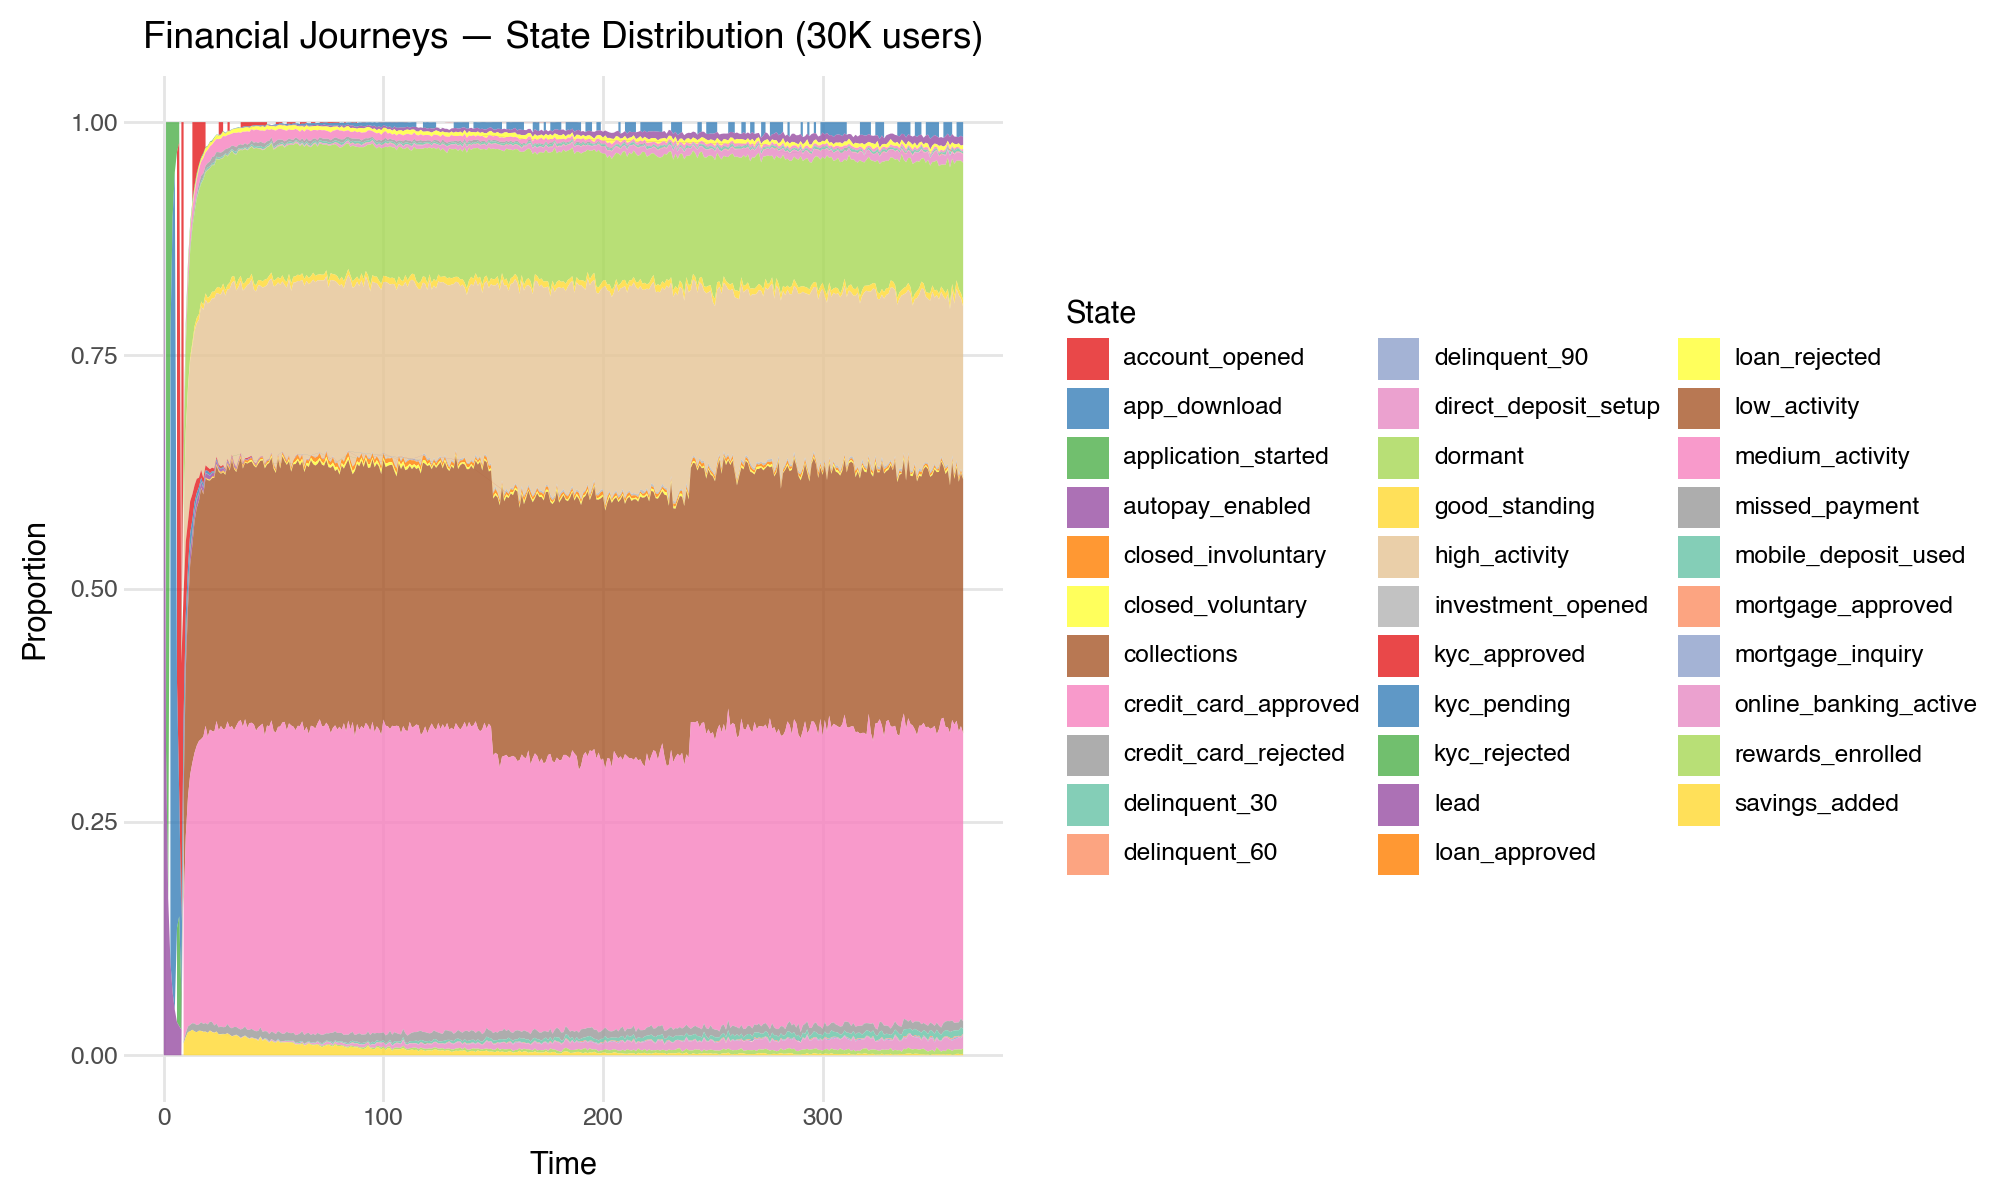

In [90]:
# Visualization at scale — distribution plot (aggregates by time, handles large data well)
distribution_plot(large_fin_seq, title="Financial Journeys — State Distribution (30K users)")

In [91]:
# Distance computation on a 200-sequence subset
large_fin_pool = SequencePool(large_fin_df.select("id", "time", "state"))
subset_pool = large_fin_pool.sample(200, seed=42)

t0 = time.perf_counter()
large_dist = subset_pool.compute_distances(method="om")
dist_time = time.perf_counter() - t0
print(f"OM distance matrix (200×200) computed in {dist_time:.2f}s")
print(f"Shape: {large_dist.shape}, Mean distance: {large_dist[np.triu_indices_from(large_dist, k=1)].mean():.4f}")

OM distance matrix (200×200) computed in 0.62s
Shape: (200, 200), Mean distance: 129.4684


## 15. Summary — API Quick Reference

| Category | Function / Class | Description |
|----------|-----------------|-------------|
| **Core** | `Alphabet` | State encoding, labels, colours |
| | `StateSequence` | Time-indexed state data |
| | `EventSequence` | Timestamped events |
| | `IntervalSequence` | Spell-based data (start/end) |
| | `SequencePool` | Optimised container for distances |
| | `Trajectory` / `TrajectoryPool` | Multi-channel entity data |
| **Statistics** | `longitudinal_entropy` | Within-sequence state diversity |
| | `transition_count` / `transition_proportion` | State transitions |
| | `sequence_length` | Sequence lengths |
| | `spell_count` | Contiguous spell count |
| | `complexity_index` | Entropy × spell structure |
| | `turbulence` / `normalized_turbulence` | Subsequence count × duration variance |
| | `subsequence_count` | Distinct non-empty subsequences |
| | `state_distribution` | Cross-sectional state frequencies |
| | `visited_states` / `visited_proportion` | Alphabet coverage |
| | `modal_states` | Most frequent state per position |
| | `mean_time_in_state` | Average time in each state |
| | `sequence_frequency_table` | Most common patterns |
| | `sequence_log_probability` | Log-likelihood under empirical model |
| **Transitions** | `transition_rate_matrix` / `transition_rates` | Transition dynamics |
| | `first_occurrence_time` | When a state first appears |
| | `state_duration_stats` | Spell duration summaries |
| | `substitution_cost_matrix` | Cost matrices for OM distances |
| **Normative** | `proportion_positive` | Time in positive states |
| | `volatility` | Sign-change frequency |
| | `precarity` | Recency-weighted negative time |
| | `insecurity` | Expected future negative proportion |
| | `integration` | Cumulative positive proportion |
| | `degradation` | Positive-to-negative transitions |
| | `badness` | Proportion in negative states |
| **Distance** | `optimal_matching_distance` | Classic OM edit distance |
| | `omloc` / `omspell` / `omstran` | OM variants |
| | `lcs` / `lcp` / `rlcp` | Subsequence/prefix metrics |
| | `dtw` / `softdtw` / `twed` | Time-warping metrics |
| | `hamming` / `dhd` | Position-based metrics |
| | `chi2` / `euclidean` | Distribution metrics |
| | `nms` / `nmsmst` / `svrspell` | Normalised match metrics |
| **Clustering** | `pam_clustering` | k-medoids (PAM) |
| | `hierarchical_clustering` | Agglomerative (4 linkage methods) |
| | `clara_clustering` | Sampling-based PAM |
| | `silhouette_score` / `cluster_quality` | Quality metrics |
| | `pam_range` | Optimal k selection |
| | `extract_representatives` | Representative sequences |
| **Mining** | `frequent_subsequences` | Frequent pattern extraction |
| **Discrepancy** | `discrepancy_analysis` | Pseudo-MANOVA for sequences |
| | `multi_factor_discrepancy` | Multi-factor tests |
| | `dissimilarity_tree` | Recursive partitioning |
| **Visualisation** | `index_plot` | Coloured sequence bars |
| | `distribution_plot` | Stacked state proportions |
| | `entropy_plot` | Positional entropy |
| | `timeline_plot` | Gantt-chart spells |
| | `frequency_plot` | Most common patterns |
| | `modal_state_plot` | Modal states over time |
| | `mean_time_plot` | Mean time per state |
| | `parallel_coordinate_plot` | Individual trajectories |
| | `spell_duration_plot` | Spell duration boxplots |
| **Filters** | `LengthCriterion` | Filter by sequence length |
| | `ContainsStateCriterion` | Filter by state presence |
| | `StartsWithCriterion` | Filter by initial state |
| | `PatternCriterion` | Filter by subsequence pattern |
| | `TimeCriterion` | Filter by time range |
| | `QueryCriterion` | Filter by Polars expression |
| | `filter_sequences` | Combine criteria (AND/OR) |
| **I/O** | `save_csv` / `load_csv` | CSV persistence |
| | `save_json` / `load_json` | JSON persistence |
| | `save_parquet` / `load_parquet` | Parquet persistence |
| | `to_wide_format` / `load_wide_format` | Wide format conversion |
| | `infer_sequence_type` | Auto-detect data type |
| **Synthetic** | `generate_markov_sequences` | Markov chain sequences |
| | `generate_financial_journeys` | Realistic banking journeys |